The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
No GPU available, using the CPU instead.


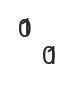

In [347]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import dataframe_image as dfi
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels
from src.data_processing import get_dataset, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.metrics import get_predictions, get_roc, get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
from src.models import FFNetPipeline

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
mpl.rcParams['figure.dpi'] = 180

import torch
from torch import optim, nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

if torch.cuda.is_available():
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device="cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'

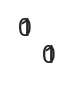

In [2]:
mpl.rcParams['figure.dpi'] = 180
sns.set_palette(HSV)
f,a = plt.subplots(1,1,figsize=(1e-7,1e-7))

# init

## reloading datasets

In [3]:
cedar_related = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')
prime_related = pd.read_csv('../data/mutant/221119_prime_related_10fold.csv')
ibel = pd.read_csv('../data/mutant/221117_ibel_merged_fold.csv')
merged = pd.read_csv('../data/mutant/221112_cedar_prime_merged_fold.csv')

In [4]:
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

## Baselines

In [13]:
from sklearn.metrics import roc_auc_score, roc_curve

3480


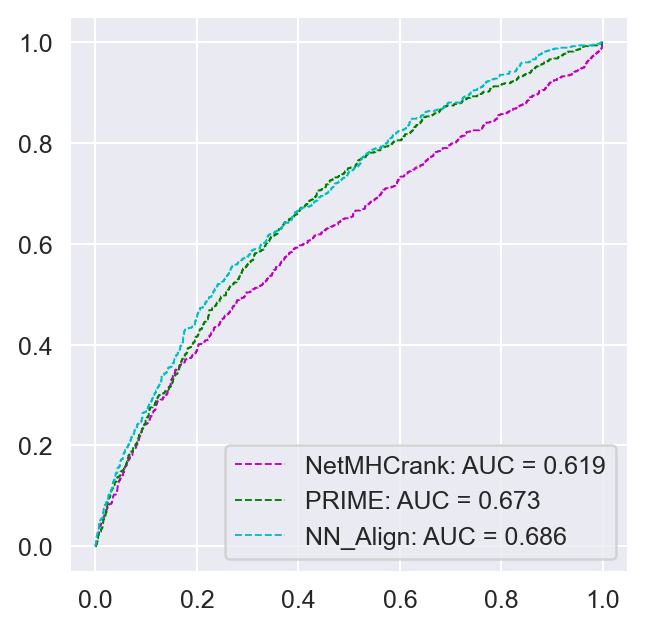

In [5]:
cedar_baseline = pd.read_csv('../data/baselines/cedar_baseline.csv')
cedar_related_baseline = pd.read_csv('../data/baselines/cedar_related_baseline.csv')
prime = pd.read_csv('../data/baselines/prime_baseline.csv')
prime_related_baseline = pd.read_csv('../data/baselines/prime_related_baseline.csv')
f,a = plt.subplots(1,1, figsize=(4,4))
plot_baseline_roc(a, cedar_baseline)
a.legend()

In [6]:
from src.baselines import plot_related_baseline_roc

In [12]:
cpeps = cedar_related_baseline.Peptide.values
ppeps = prime_related_baseline.Peptide.values
cp_common_peps = [x for x in cpeps if x in ppeps]
len(ibel.query('Peptide not in @cpeps and Peptide not in @ppeps')), len(ibel)

(86, 94)

In [ ]:
cedar_related_baseline.query('Peptide not in 

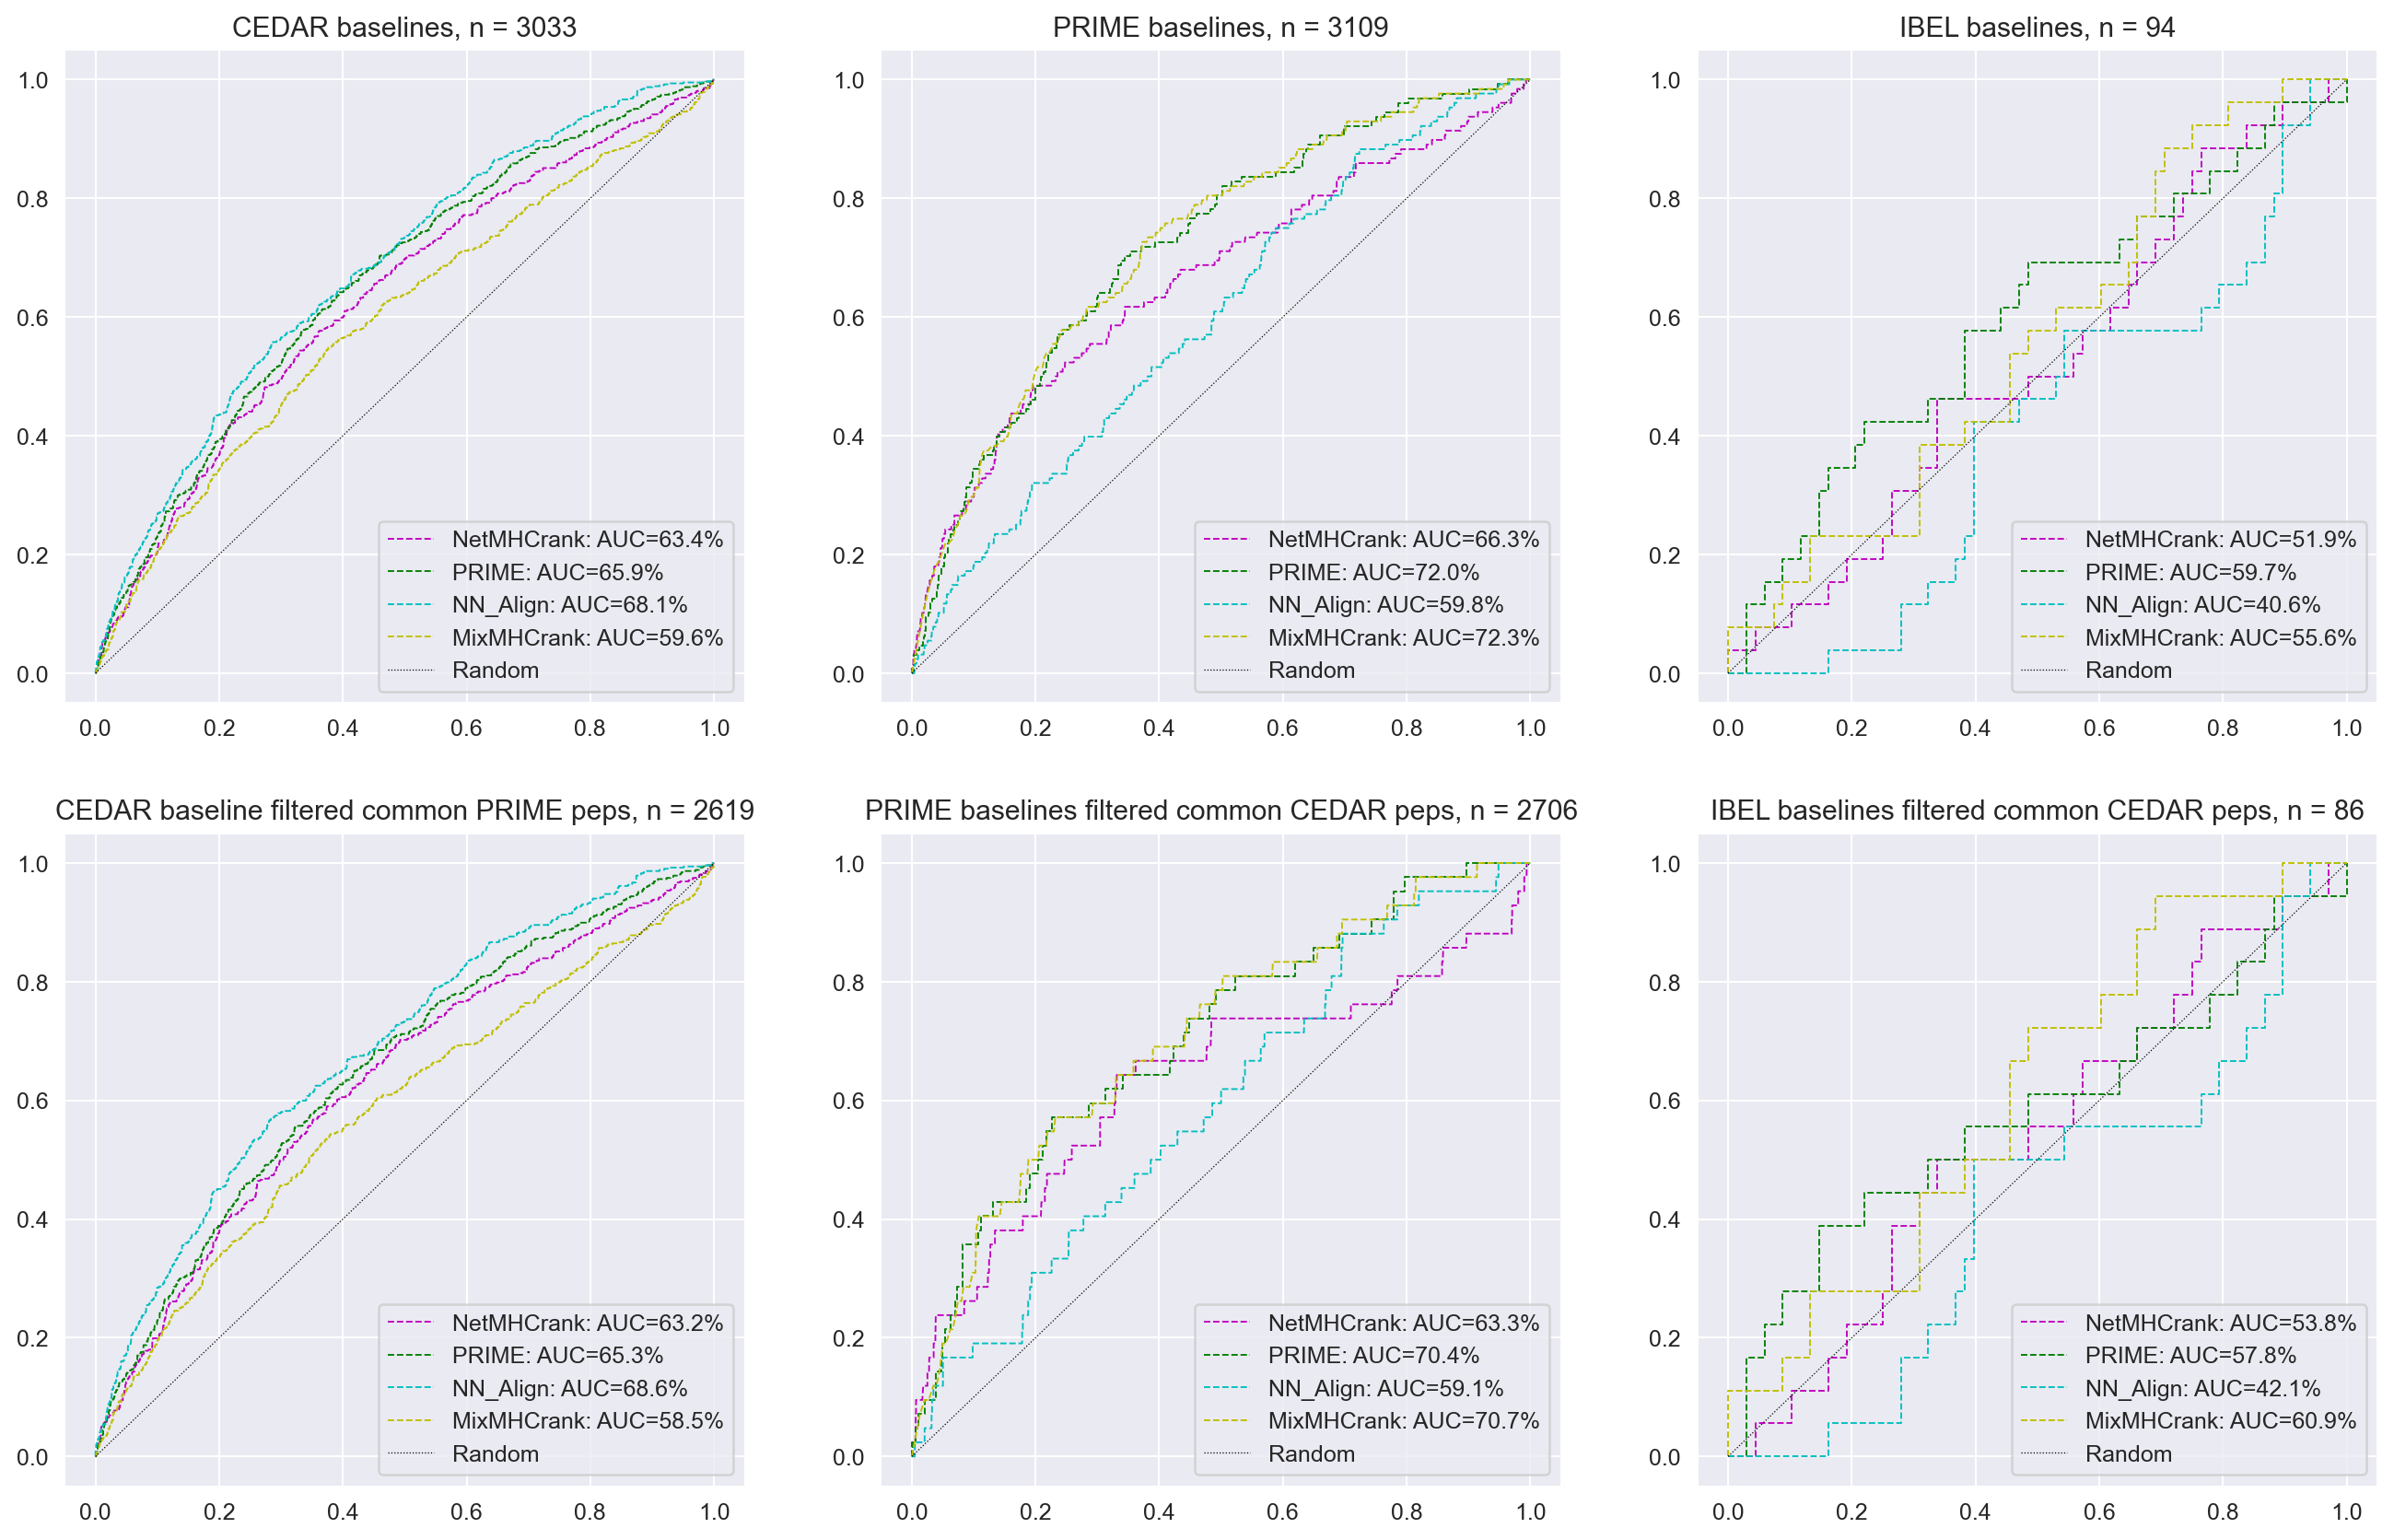

In [341]:
f,a = plt.subplots(2,3, figsize=(18,11.25))
a = a.ravel()
plot_related_baseline_roc(a[0], dataset=cedar_related_baseline)
plot_related_baseline_roc(a[1], dataset=prime_related_baseline)
plot_related_baseline_roc(a[2], dataset=ibel)

plot_related_baseline_roc(a[3], dataset=cedar_related_baseline.query('Peptide not in @ppeps'))
plot_related_baseline_roc(a[4], dataset=prime_related_baseline.query('Peptide not in @cpeps'))
plot_related_baseline_roc(a[5], dataset=ibel.query('Peptide not in @cpeps and Peptide not in @ppeps'))

a[0].set_title(f'CEDAR baselines, n = {len(cedar_related_baseline)}')
a[1].set_title(f'PRIME baselines, n = {len(prime_related_baseline)}')
a[2].set_title(f'IBEL baselines, n = {len(ibel)}')
a[3].set_title(f'CEDAR baseline filtered common PRIME peps, n = {len(cedar_related_baseline.query("Peptide not in @ppeps"))}')
a[4].set_title(f'PRIME baselines filtered common CEDAR peps, n = {len(prime_related_baseline.query("Peptide not in @cpeps"))}')
a[5].set_title(f'IBEL baselines filtered common CEDAR peps, n = {len(ibel.query("Peptide not in @cpeps and Peptide not in @ppeps"))}')

a[0].legend(loc = 'lower right')
a[1].legend(loc = 'lower right')
a[2].legend(loc = 'lower right')
a[3].legend(loc = 'lower right')
a[4].legend(loc = 'lower right')
a[5].legend(loc = 'lower right')

In [14]:
tmp = ibel.query('Peptide not in @cpeps and Peptide not in @ppeps')
roc_auc_score(tmp['agg_label'], tmp['PRIME_score'])

0.5784313725490196

# Features figure

In [351]:
cols = ['HLA', 'agg_label', 'Peptide', 'wild_type', 'Peptide_mut', 'Peptide_wt', 'icore_mut', 'icore_wt', 'core_wt', 'core_mut', 'EL_rank_mut', 'EL_rank_wt']

In [379]:
cedar_related.query('HLA=="HLA-A0201" and agg_label==1 and len == 10 and icore_mut!=Peptide')[cols]

,HLA,agg_label,Peptide,wild_type,Peptide_mut,Peptide_wt,icore_mut,icore_wt,core_wt,core_mut,EL_rank_mut,EL_rank_wt
6,HLA-A0201,1,AALLQVTLLL,AALSQVTLLL,ALLQVTLLL,ALSQVTLLL,ALLQVTLLL,ALSQVTLLL,ALSQVTLLL,ALLQVTLLL,0.0995,0.1342
83,HLA-A0201,1,ALLETPSLLL,ALLETLSLLL,ALLETPSLL,ALLETLSLL,ALLETPSLL,ALLETLSLL,ALLETLSLL,ALLETPSLL,0.0446,0.0363
126,HLA-A0201,1,AMPFSIFYPM,AMPFSIFYRM,AMPFSIFYP,AMPFSIFYRM,AMPFSIFYP,AMPFSIFYRM,AMPFSIFYM,AMPFSIFYP,5.4917,5.1194
282,HLA-A0201,1,CQQWLALFFV,CQQRLALFFV,QQWLALFFV,QQRLALFFV,QQWLALFFV,QQRLALFFV,QQRLALFFV,QQWLALFFV,0.9250,4.8556
416,HLA-A0201,1,FAVGSYVYSV,FAVGSHVYSV,AVGSYVYSV,AVGSHVYSV,AVGSYVYSV,AVGSHVYSV,AVGSHVYSV,AVGSYVYSV,0.1353,0.0962
458,HLA-A0201,1,FISIFFFLEI,FISIFSFLEI,FISIFFFL,SIFSFLEI,FISIFFFL,SIFSFLEI,SIF-SFLEI,FIS-IFFFL,6.3149,4.5040
466,HLA-A0201,1,FLAPLFLVLL,FLAPLFMVLL,FLAPLFLVL,FLAPLFMVL,FLAPLFLVL,FLAPLFMVL,FLAPLFMVL,FLAPLFLVL,0.0426,0.0421
517,HLA-A0201,1,FLMASISSFL,FLMASISSSL,LMASISSFL,LMASISSSL,LMASISSFL,LMASISSSL,LMASISSSL,LMASISSFL,0.3946,0.3709
537,HLA-A0201,1,FLSNFIILML,FLSNFIIQML,FLSNFIILM,FLSNFIIQM,FLSNFIILM,FLSNFIIQM,FLSNFIIQM,FLSNFIILM,0.1204,0.0343
560,HLA-A0201,1,FMDMAILVES,FMDMAMLVES,FMDMAILV,FMDMAMLV,FMDMAILV,FMDMAMLV,FM-DMAMLV,FM-DMAILV,1.5805,1.7867


In [380]:
s1 = cedar_related.loc[[282]].assign(type='Mutant')[['type','HLA', 'Peptide', 'icore_mut', 'core_mut', 'EL_rank_mut']].rename(columns={'Peptide':'Sequence', 'icore_mut':'icore', 'core_mut':'core', 'EL_rank_mut':'EL_rank'})
s2 = cedar_related.loc[[282]].assign(type='Wild-Type')[['type','HLA', 'wild_type', 'icore_wt', 'core_wt', 'EL_rank_wt']].rename(columns={'wild_type':'Sequence', 'icore_wt':'icore', 'core_wt':'core', 'EL_rank_wt':'EL_rank'})
pd.concat([s1,s2]).reset_index(drop=True)

,type,HLA,Sequence,icore,core,EL_rank
0,Mutant,HLA-A0201,CQQWLALFFV,QQWLALFFV,QQWLALFFV,0.9250
1,Wild-Type,HLA-A0201,CQQRLALFFV,QQRLALFFV,QQRLALFFV,4.8556


# Indep eval / benchmarking on raw preds

In [87]:
pdir = '../output/221122_mutscore_cedar_fixed/230116_preds_copy_noRatio_noSwitch/'
fs = sorted(filter(lambda x: 'Peptide_trueHLA' in x or 'icore_mut_EL_rank' in x, os.listdir(pdir)))
ommited = [x for x in ppeps if x not in pd.read_csv(f'{pdir}{fs[-1]}').Peptide.values]
len(fs)

1890

In [313]:
def get_fn(encoding, weight, pep_col, rank_col, key):
    fn = f"{encoding}_{weight.replace(' ','-')}_{pep_col}_{rank_col}_{key}"
    return fn
def get_fi(encoding, weight, pep_col, rank_col, key, pdir='../output/221122_mutscore_cedar_fixed/230116_preds_copy_noRatio_noSwitch/'):
    fn = f"featimps_{get_fn(encoding, weight, pep_col, rank_col, key)}.csv".replace('BL62LO','blosum').replace('BL62FREQ','blosum')
    return pd.read_csv(f'{pdir}{fn}')
def get_pred(evalset, encoding, weight, pep_col, rank_col, key, pdir='../output/221122_mutscore_cedar_fixed/230116_preds_copy_noRatio_noSwitch/'):
    fn = f"{evalset.lower()}_preds_{get_fn(encoding, weight, pep_col, rank_col, key)}.csv"
    return pd.read_csv(f'{pdir}{fn}')

In [298]:
gb_agg = pd.read_csv('../output/221122_mutscore_cedar_fixed/gb_agg.csv')
gb_agg['mean_auc_agg'] = .5*(gb_agg['mean_auc_CEDAR']+gb_agg['mean_auc_PRIME'])
gb_agg['mean_auc_std'] = gb_agg.apply(lambda x: np.std([x['mean_auc_CEDAR'],x['mean_auc_PRIME']]), axis=1)
gb_agg['agg_selection'] = gb_agg.apply(lambda x: .5*x['mean_auc_CEDAR']+.3 * x['mean_auc_agg'] + .2 * (1-x['mean_auc_std']), axis = 1)
auc_cols = [x for x in gb_agg.columns if 'auc' in x.lower() or x=='agg_selection']
cdt_cols = ['encoding', 'weight', 'pep_col', 'rank_col', 'key']
gb_agg = gb_agg[['encoding', 'weight', 'pep_col', 'rank_col', 'key']+auc_cols]


In [343]:
gb_agg.sort_values('mean_auc_IBEL', ascending=False).head(1)

,encoding,weight,pep_col,rank_col,key,mean_auc_CEDAR,mean_auc_PRIME,mean_auc_IBEL,mean_auc_agg,mean_auc_std,agg_selection
348,BL62LO,Mask,Peptide,trueHLA_EL_rank,dissimilarity_score-core_blsm_mut_score,0.68402,0.676707,0.661289,0.680363,0.003656,0.745388


In [129]:
best_models = {}
for col in filter(lambda x: x!='mean_auc_agg' and x !='mean_auc_std',auc_cols):
    print(col)
    display(gb_agg.sort_values(col, ascending=False).head(3))
    c = col.replace('mean_auc_', 'Best for ')
    best_models[c] = {}
    best_models[c]['cdt'] = gb_agg.sort_values(col, ascending=False).head(1)[cdt_cols].squeeze().to_dict()

mean_auc_CEDAR


,encoding,weight,pep_col,rank_col,key,mean_auc_CEDAR,mean_auc_PRIME,mean_auc_IBEL,mean_auc_agg,mean_auc_std,agg_selection
481,onehot,Inverted Shannon,icore_mut,EL_rank_mut,aa_props,0.727794,0.642723,0.531257,0.685259,0.042535,0.760968
421,onehot,Inverted KL,icore_mut,EL_rank_mut,aa_props,0.726676,0.641571,0.534083,0.684124,0.042552,0.760065
420,onehot,Inverted KL,Peptide,trueHLA_EL_rank,aa_props,0.722811,0.654043,0.529108,0.688427,0.034384,0.761057


mean_auc_PRIME


,encoding,weight,pep_col,rank_col,key,mean_auc_CEDAR,mean_auc_PRIME,mean_auc_IBEL,mean_auc_agg,mean_auc_std,agg_selection
549,onehot,Mask,icore_mut,EL_rank_mut,core_blsm_mut_score-core_mutation_score,0.706017,0.703309,0.591876,0.704663,0.001354,0.764137
545,onehot,Mask,icore_mut,EL_rank_mut,blsm_mut_score-mutation_score,0.705828,0.699351,0.608903,0.702590,0.003239,0.763043
543,onehot,Mask,icore_mut,EL_rank_mut,blsm_mut_score,0.705893,0.699349,0.611067,0.702621,0.003272,0.763078


mean_auc_IBEL


,encoding,weight,pep_col,rank_col,key,mean_auc_CEDAR,mean_auc_PRIME,mean_auc_IBEL,mean_auc_agg,mean_auc_std,agg_selection
348,BL62LO,Mask,Peptide,trueHLA_EL_rank,dissimilarity_score-core_blsm_mut_score,0.684020,0.676707,0.661289,0.680363,0.003656,0.745388
350,BL62LO,Mask,Peptide,trueHLA_EL_rank,dissimilarity_score-core_blsm_mut_score-core_m...,0.684068,0.676156,0.660834,0.680112,0.003956,0.745276
346,BL62LO,Mask,Peptide,trueHLA_EL_rank,dissimilarity_score-blsm_mut_score-mutation_score,0.684585,0.675190,0.658868,0.679888,0.004697,0.745319


agg_selection


,encoding,weight,pep_col,rank_col,key,mean_auc_CEDAR,mean_auc_PRIME,mean_auc_IBEL,mean_auc_agg,mean_auc_std,agg_selection
525,onehot,KL,icore_mut,EL_rank_mut,dissimilarity_score-blsm_mut_score,0.718283,0.681642,0.607006,0.699962,0.018320,0.765466
615,onehot,Shannon,icore_mut,EL_rank_mut,dissimilarity_score-blsm_mut_score,0.718035,0.679810,0.609920,0.698922,0.019112,0.764872
617,onehot,Shannon,icore_mut,EL_rank_mut,dissimilarity_score-blsm_mut_score-mutation_score,0.718130,0.678767,0.613869,0.698449,0.019682,0.764663


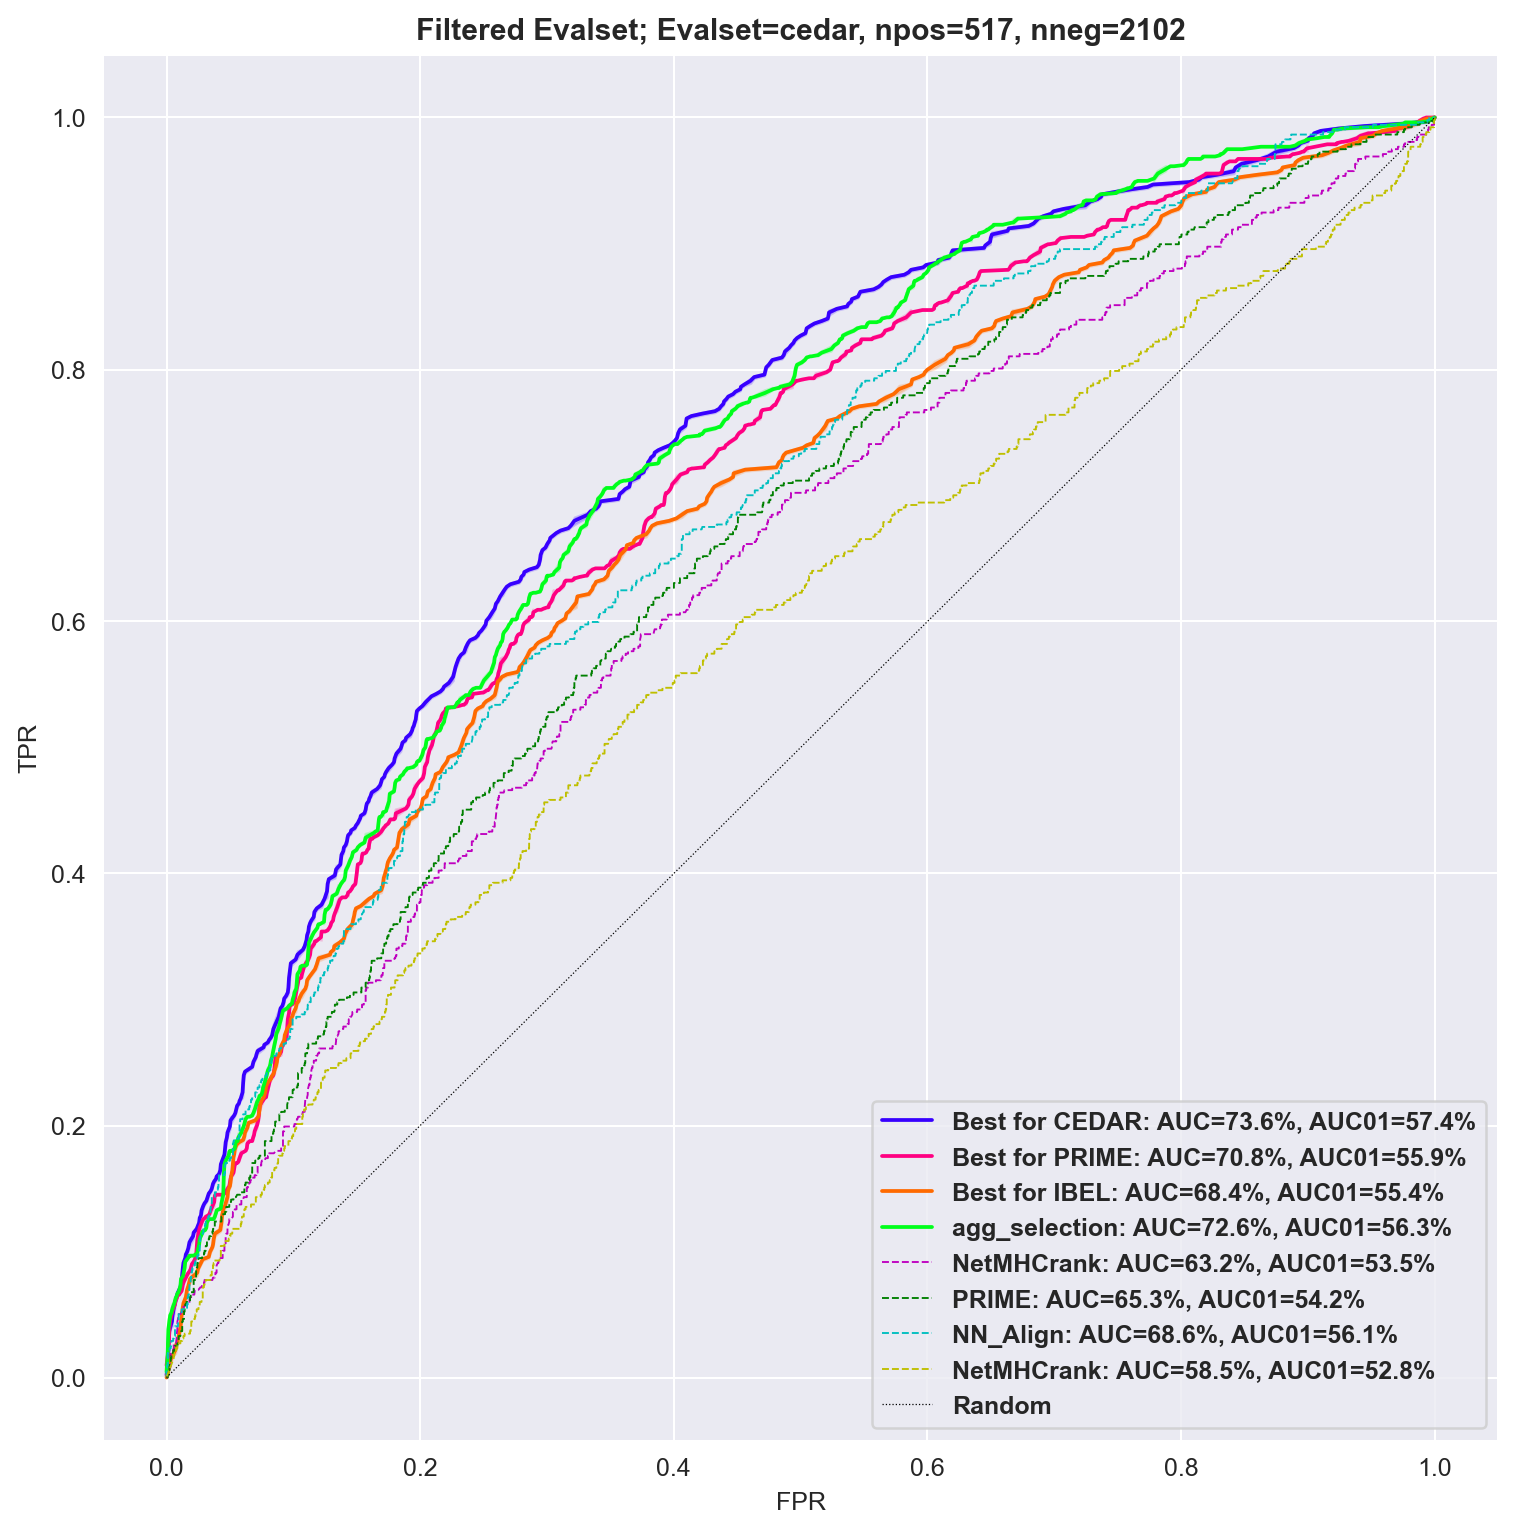

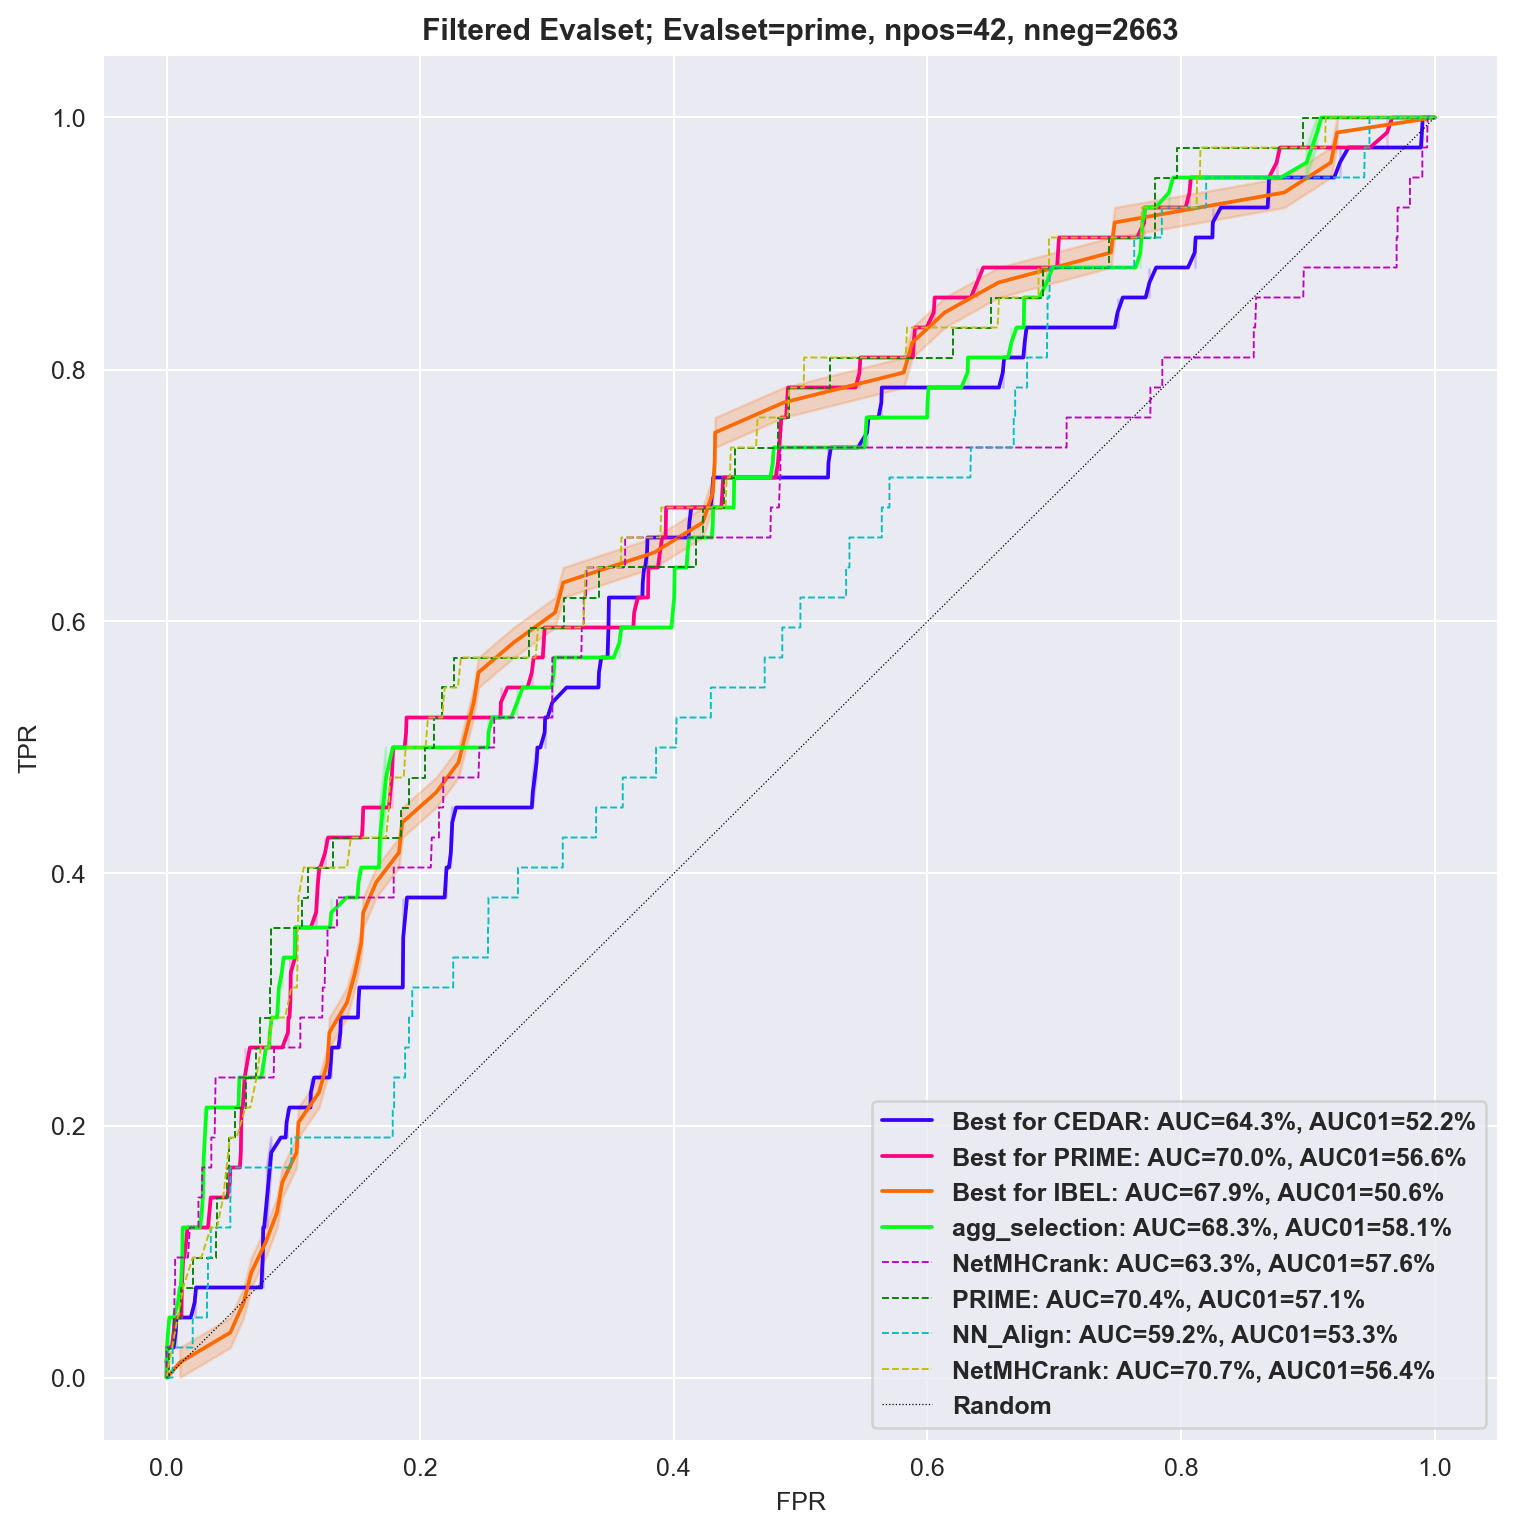

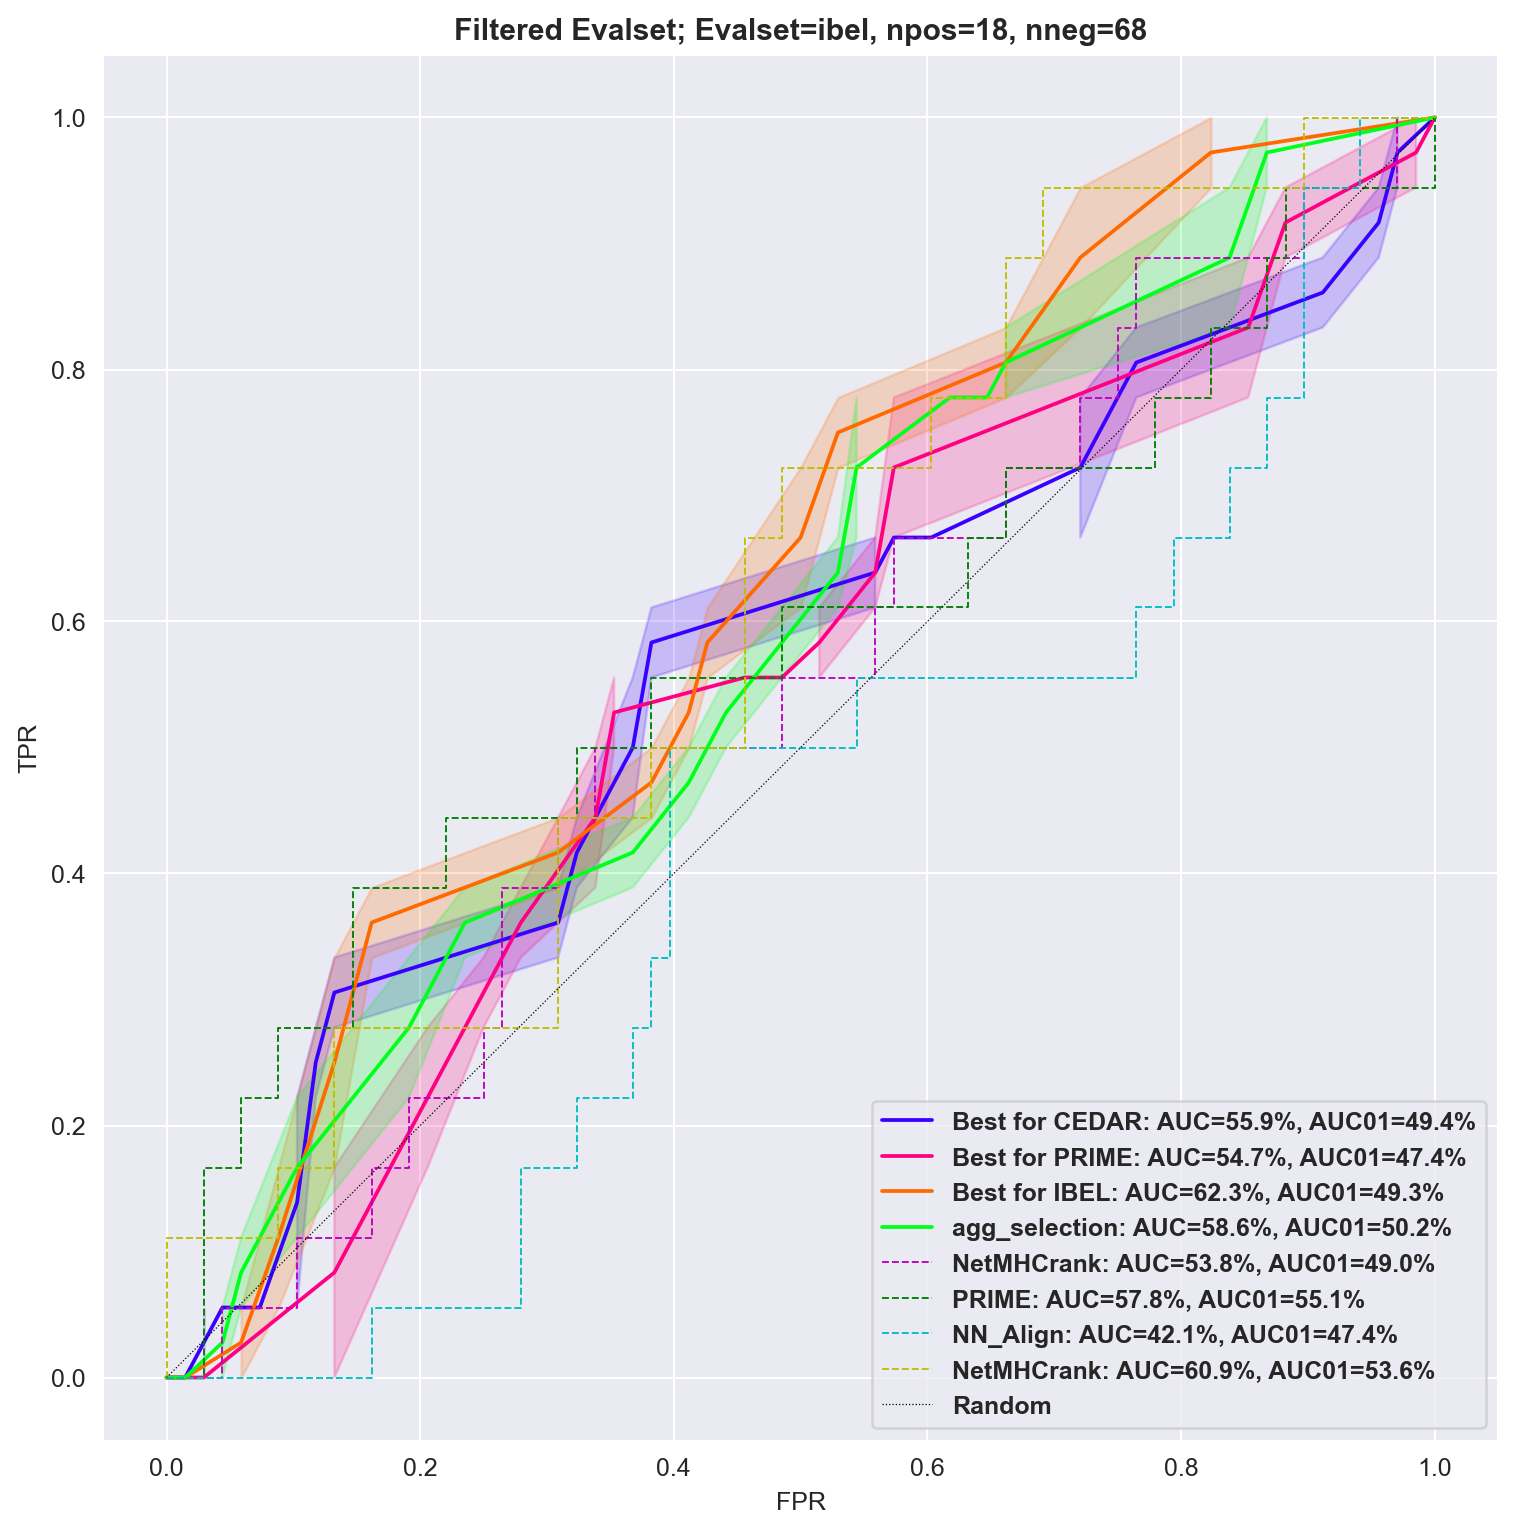

In [143]:
sns.set_palette(HSV)
for evalset,baseline in zip(['cedar', 'prime', 'ibel'],
                            [cedar_related_baseline, prime_related_baseline, ibel]):
    f,a = plt.subplots(1,1,figsize=(10,10))
    query = 'Peptide not in @cp_common_peps and Peptide not in @ommited' if (evalset =='cedar' or evalset=='prime') \
            else 'Peptide not in @cpeps and Peptide not in @ppeps and Peptide not in @ommited'
    
    for k in best_models:
        best_models[k][evalset] = get_pred(evalset, **best_models[k]['cdt'])
        pcol = 'pred' if 'pred' in best_models[k][evalset].columns else 'mean_pred'
        tmp = best_models[k][evalset].query(query)
        auc = roc_auc_score(tmp['agg_label'].astype(int), tmp[pcol].values)
        auc01 = roc_auc_score(tmp['agg_label'].astype(int), tmp[pcol].values, max_fpr=0.1)
        fpr, tpr, _ = roc_curve(tmp['agg_label'].astype(int), tmp[pcol].values)
        sns.lineplot(x=fpr, y=tpr, label = f'{k}: AUC={auc:.1%}, AUC01={auc01:.1%}', ax=a)
    
    bs = baseline.query(query + ' and Peptide in @tmp.Peptide.values')
    plot_related_baseline_roc(a, bs, auc01=True)
    a.legend(loc='lower right', prop=dict(weight='semibold'))
    a.set_title(f'Filtered Evalset; Evalset={evalset}, '\
                f'npos={len(bs.query("agg_label==1"))}, '\
                f'nneg={len(bs.query("agg_label==0"))}', fontweight='semibold')
    a.set_xlabel('FPR')
    a.set_ylabel('TPR')
    f.savefig(f'../../../meetings/slides/2301XX_CEDAR_meeting_update/filtered_evalset_{evalset}_vs_baselines_rocs.png',
              bbox_inches='tight', dpi=200)

In [346]:
BL62_VALUES['W']

array([-3, -3, -4, -4, -2, -2, -3, -2, -2, -3, -2, -3, -1,  1, -4, -3, -2,
       11,  2, -3])

In [271]:
from src.bootstrap import bootstrap_eval
# Here, for each of the evalsets and conditions, 
# gets pvalues with the best cdt vs the rests
# Rebootstrap the AUCs
rebootstrapped_best = {}


for evalname, evalset in zip(['cedar', 'prime' ,'ibel'], [cedar_related_baseline, prime_related_baseline, ibel]):
    tmp = []
    for k in best_models:
        pcol = 'pred' if 'pred' in best_models[k][evalname].columns else 'mean_pred'
        scores = best_models[k][evalname][pcol].values
        labels = best_models[k][evalname]['agg_label'].astype(int)
        bootstrapped_df = bootstrap_eval(scores, labels, n_rounds=10000, n_jobs=8)[0].assign(evalset=evalname, key=k)
        tmp.append(bootstrapped_df)
    
    # Bootstrap PRIME and NN align as baseline on the boxplots?    
    for baseline in [x for x in cedar_related_baseline.columns if 'score' in x.lower()]:
        scores = evalset[baseline].values
        labels = evalset['agg_label'].astype(int)
        bootstrapped_baseline = bootstrap_eval(scores, labels, n_rounds=10000, n_jobs=8)[0].assign(evalset=evalname, key=baseline)
        tmp.append(bootstrapped_baseline)
    rebootstrapped_best[evalname] = pd.concat(tmp)

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


In [278]:
for evalset in rebootstrapped_best:
    rebootstrapped_best[evalset]['key']=rebootstrapped_best[evalset]['key'].apply(lambda x : x.replace('_score', ''))

0.0
0.0
0.0
0.0
0.0
0.0


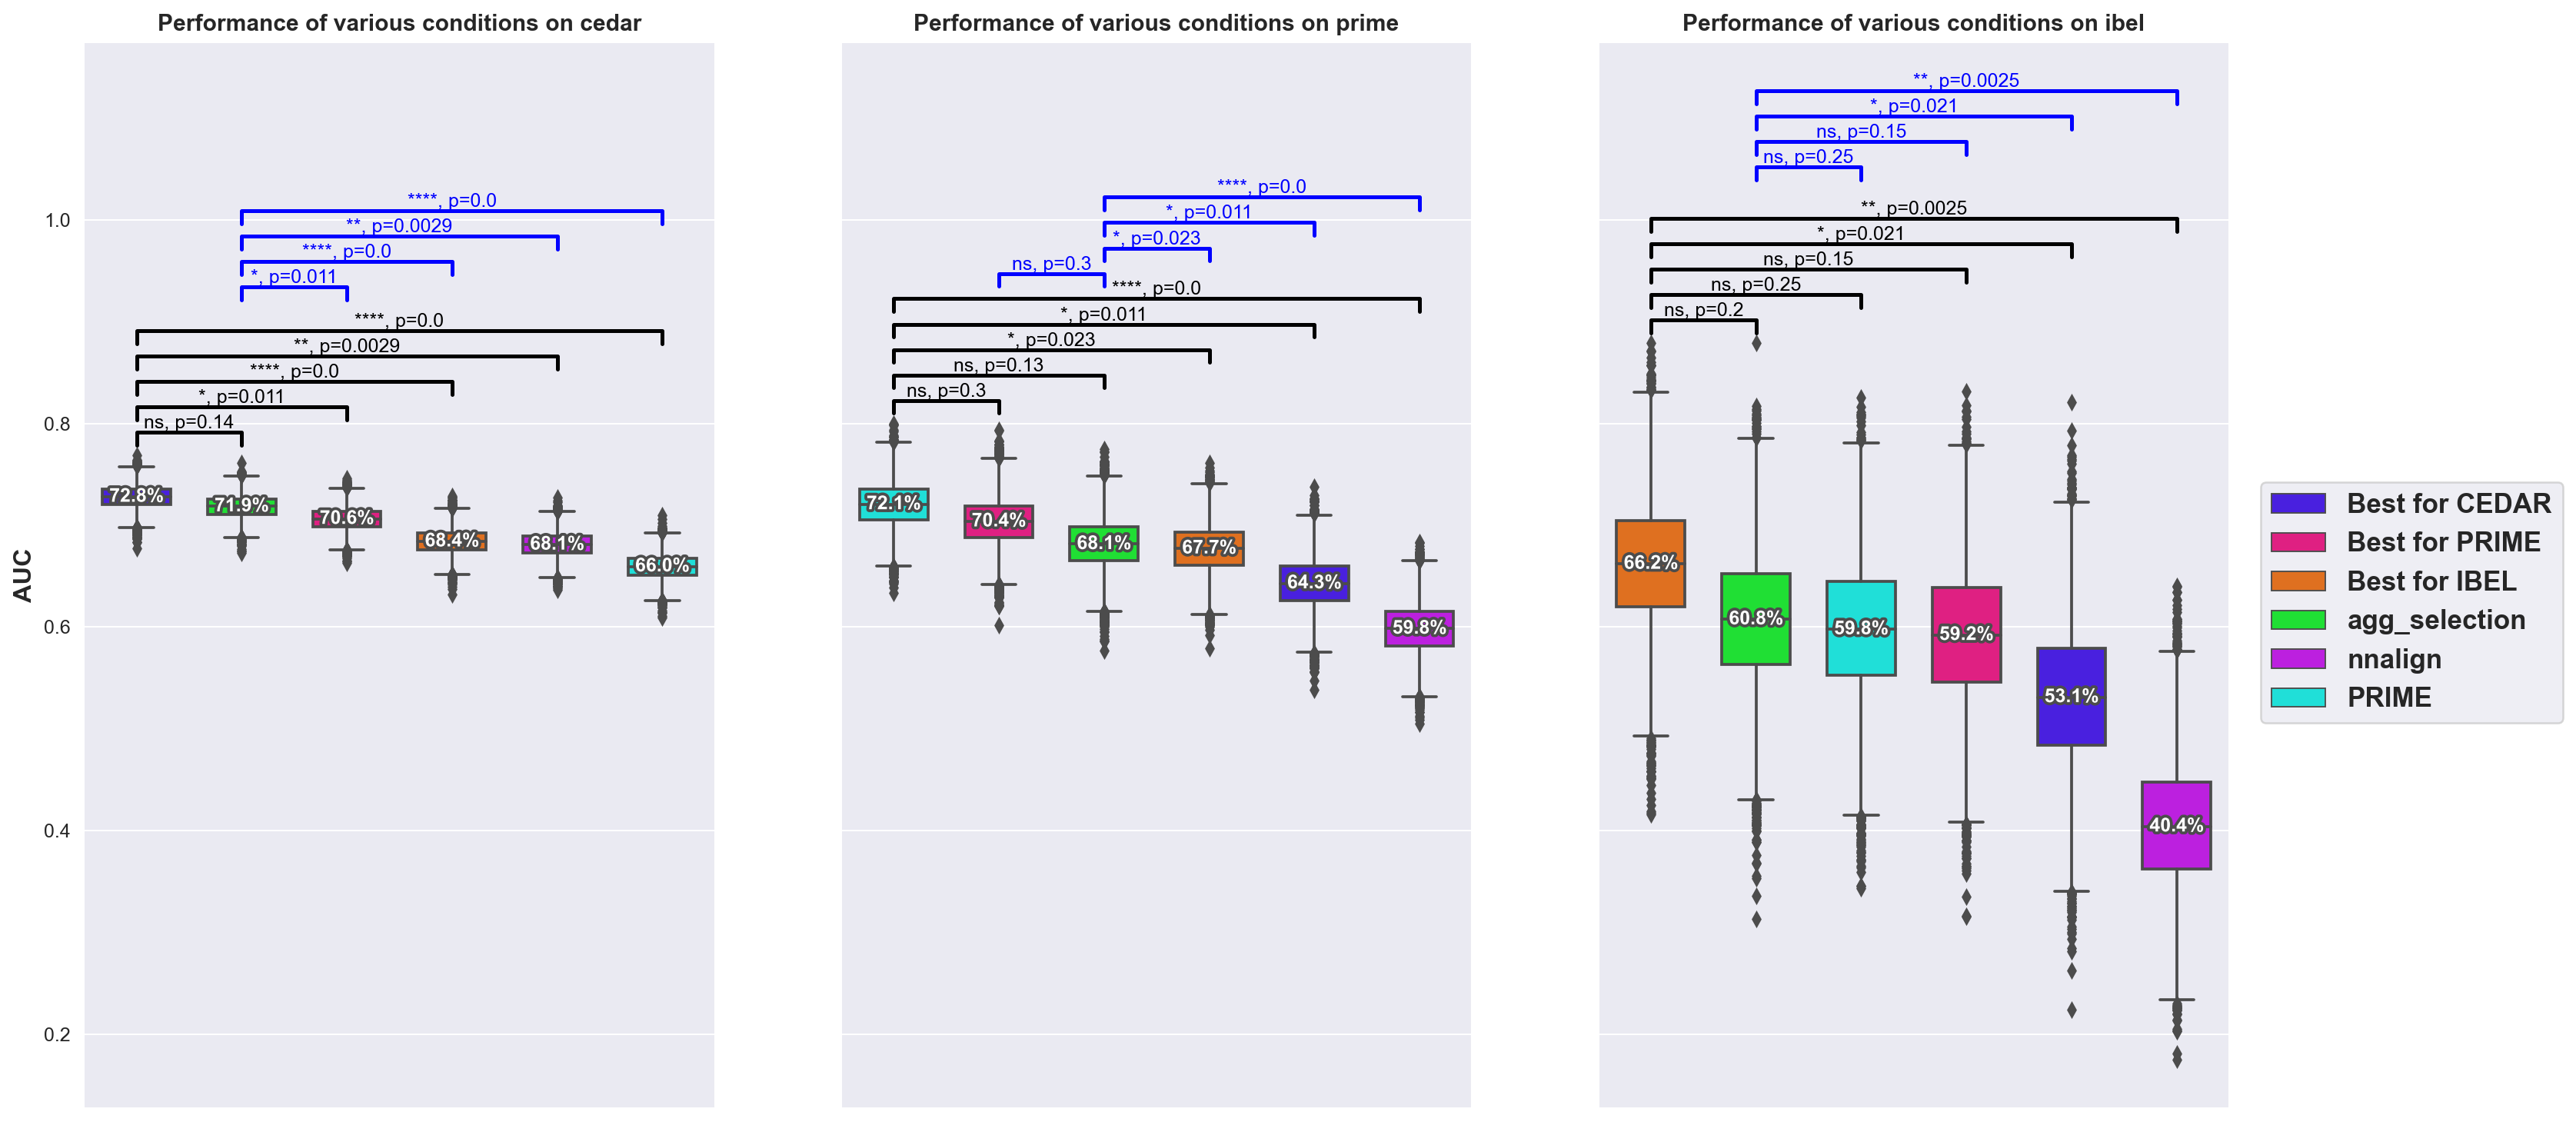

In [292]:
from src.bootstrap import get_pval, plot_pval
f,a = plt.subplots(1,3, figsize=(20,10), sharey=True)
order = ['Best for CEDAR', 'Best for PRIME', 'Best for IBEL', 'agg_selection', 'nnalign', 'PRIME']
tmppal = sns.color_palette('hsv', n_colors=15)
NEWPAL = HSV + [tmppal[-3], tmppal[7]]
color_order = {k:v for k,v in zip(order, NEWPAL)}
for evalset,axis in zip(rebootstrapped_best, a):
    # Sort order by decreasing performance
    sorted_order = rebootstrapped_best[evalset].groupby('key').agg(mean_auc=('auc','mean'))\
                                               .sort_values('mean_auc', ascending=False).index.tolist()
    sns.boxplot(data = rebootstrapped_best[evalset], x = 'key', y = 'auc', width=.65, ax=axis, 
                palette = color_order, order = sorted_order, hue = 'key', dodge=False)
    # Add median and remove legend / ylabel
    add_median_labels(axis, fmt = '.1%')
    axis.legend([], frameon=False)
    axis.set_ylabel('')
    axis.set_xlabel('')
    # axis.set_xticklabels(axis.get_xticklabels(), fontweight = 'semibold', fontsize=13, rotation=45, ha='center')
    axis.set_xticklabels([])
    axis.set_title(f'Performance of various conditions on {evalset}', fontweight='semibold')
    # Comparing with aucs_base, which is the best one
    aucs_base = rebootstrapped_best[evalset].query('key == @sorted_order[0]').auc.values
    h, h0 = 0.01, 0.0125
    x0 = 0
    for i, comparison in enumerate(sorted_order[1:]):
        x1 = sorted_order.index(comparison)
        aucs_comp = rebootstrapped_best[evalset].query('key == @comparison').auc.values
        pval, sig = get_pval(aucs_base, aucs_comp)
        plot_pval(axis, pval, sig, x0, x1, y = max(aucs_base)+h, h=h0, color='k')
        h += 2 * h0
    
    # Comparing "agg_selection" with the lower 2
    new_order = [x for x in sorted_order if x != sorted_order[0] and x != 'agg_selection']
    new_order = ['agg_selection'] + new_order
    aucs_agg = rebootstrapped_best[evalset].query('key == "agg_selection"').auc.values
    x0 = sorted_order.index('agg_selection')
    h += 2*h0
    for i, comparison in enumerate(new_order[1:]):
        x1 = sorted_order.index(comparison)
        aucs_comp = rebootstrapped_best[evalset].query('key == @comparison').auc.values
        pval, sig = get_pval(aucs_base, aucs_comp)
        plot_pval(axis, pval, sig, x0, x1, y = max(aucs_agg)+h, h=h0, color = 'b')
        h += 2*h0

a[0].set_ylabel('AUC', fontweight='semibold', fontsize=13)

h, l = a[1].get_legend_handles_labels()
# new_labels = ['    '.join([x for x in [':'.join([k,v]) for k,v in best_models[BEST_CDT]['cdt'].items()]]) for BEST_CDT in l]
# bbox = (.75, -0.05)
bbox = (2.75, 0.6)
a[1].legend(h, l, bbox_to_anchor = bbox,prop=dict(weight='semibold', size = 14))
f.savefig('../../../meetings/slides/2301XX_CEDAR_meeting_update/boxplot_best_cdt.png', bbox_inches='tight', dpi=200)

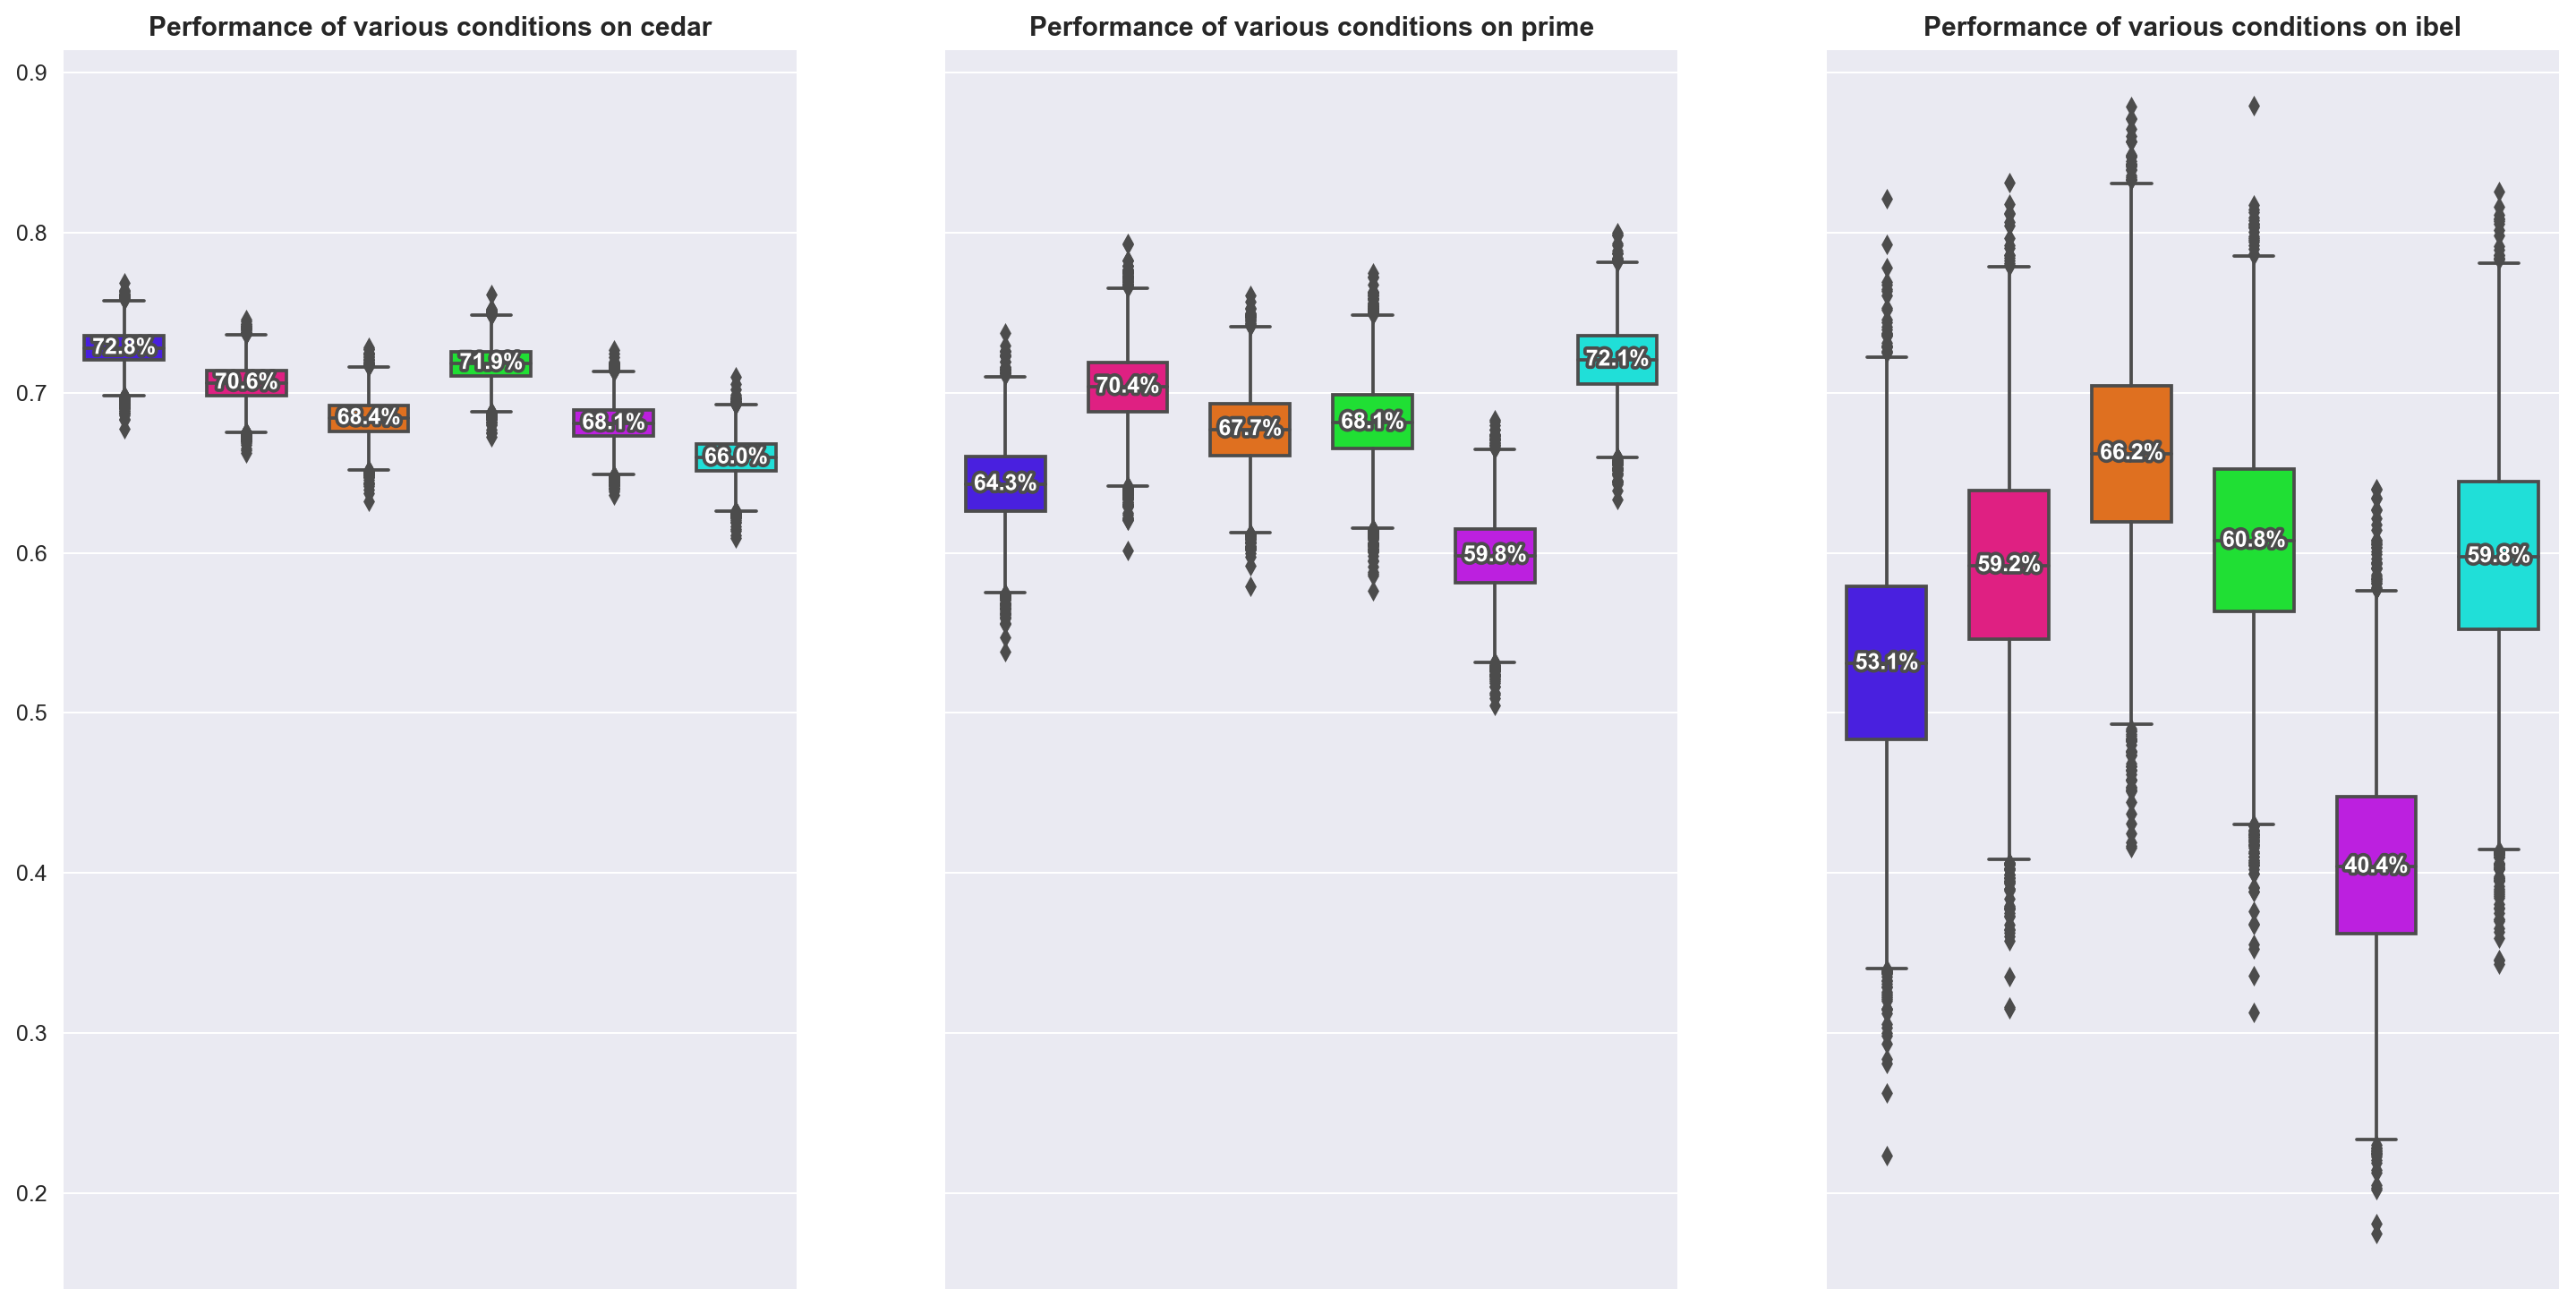

In [ ]:
# Redo the plot but keeping the order and redo not all the p-values

f,a = plt.subplots(1,3, figsize=(20,10), sharey=True)
order = ['Best for CEDAR', 'Best for PRIME', 'Best for IBEL', 'agg_selection', 'nnalign', 'PRIME']
tmppal = sns.color_palette('hsv', n_colors=15)
NEWPAL = HSV + [tmppal[-3], tmppal[7]]
color_order = {k:v for k,v in zip(order, NEWPAL)}
for evalset,axis in zip(rebootstrapped_best, a):
    # Sort order by decreasing performance
    
    sns.boxplot(data = rebootstrapped_best[evalset], x = 'key', y = 'auc', width=.65, ax=axis, 
                palette = color_order, order = order, hue = 'key', dodge=False)
    # Add median and remove legend / ylabel
    add_median_labels(axis, fmt = '.1%')
    axis.legend([], frameon=False)
    axis.set_ylabel('')
    axis.set_xlabel('')
    # axis.set_xticklabels(axis.get_xticklabels(), fontweight = 'semibold', fontsize=13, rotation=45, ha='center')
    axis.set_xticklabels([])
    axis.set_title(f'Performance of various conditions on {evalset}', fontweight='semibold')
    # Comparing with aucs_base, which is the best one
    aucs_base = rebootstrapped_best[evalset].query('key == @sorted_order[0]').auc.values
    h, h0 = 0.01, 0.0125
    x0 = 0
    for i, comparison in enumerate(sorted_order[1:]):
        x1 = sorted_order.index(comparison)
        aucs_comp = rebootstrapped_best[evalset].query('key == @comparison').auc.values
        pval, sig = get_pval(aucs_base, aucs_comp)
        plot_pval(axis, pval, sig, x0, x1, y = max(aucs_base)+h, h=h0, color='k')
        h += 2 * h0
    
    # Comparing "agg_selection" with the lower 2
    new_order = [x for x in sorted_order if x != sorted_order[0] and x != 'agg_selection']
    new_order = ['agg_selection'] + new_order
    aucs_agg = rebootstrapped_best[evalset].query('key == "agg_selection"').auc.values
    x0 = sorted_order.index('agg_selection')
    h += 2*h0
    for i, comparison in enumerate(new_order[1:]):
        x1 = sorted_order.index(comparison)
        aucs_comp = rebootstrapped_best[evalset].query('key == @comparison').auc.values
        pval, sig = get_pval(aucs_base, aucs_comp)
        plot_pval(axis, pval, sig, x0, x1, y = max(aucs_agg)+h, h=h0, color = 'b')
        h += 2*h0

a[0].set_ylabel('AUC', fontweight='semibold', fontsize=13)

h, l = a[1].get_legend_handles_labels()
# new_labels = ['    '.join([x for x in [':'.join([k,v]) for k,v in best_models[BEST_CDT]['cdt'].items()]]) for BEST_CDT in l]
# bbox = (.75, -0.05)
bbox = (2.75, 0.6)
a[1].legend(h, l, bbox_to_anchor = bbox,prop=dict(weight='semibold', size = 14))
f.savefig('../../../meetings/slides/2301XX_CEDAR_meeting_update/boxplot_best_cdt.png', bbox_inches='tight', dpi=200)

In [241]:
[' '.join([x for x in [':'.join([k,v]) for k,v in best_models[BEST_CDT]['cdt'].items()]]) for BEST_CDT in l]


['encoding:onehot weight:Inverted Shannon pep_col:icore_mut rank_col:EL_rank_mut key:aa_props',
 'encoding:onehot weight:Mask pep_col:icore_mut rank_col:EL_rank_mut key:core_blsm_mut_score-core_mutation_score',
 'encoding:BL62LO weight:Mask pep_col:Peptide rank_col:trueHLA_EL_rank key:dissimilarity_score-core_blsm_mut_score',
 'encoding:onehot weight:KL pep_col:icore_mut rank_col:EL_rank_mut key:dissimilarity_score-blsm_mut_score']

# Best models feature importances

In [309]:
fis.values

array([[0.01778857, 0.01836067, 0.00727747, 0.03401974, 0.01356186,
        0.01390138, 0.02238665, 0.01333453, 0.01261413, 0.02214667,
        0.05401134, 0.01520979, 0.02420448, 0.02849872, 0.01895476,
        0.04092312, 0.01455775, 0.00637256, 0.01946641, 0.02902174,
        0.16109845, 0.04900776, 0.06300183, 0.05585027, 0.03083919,
        0.08437477, 0.05067476, 0.0375934 , 0.04094724]])

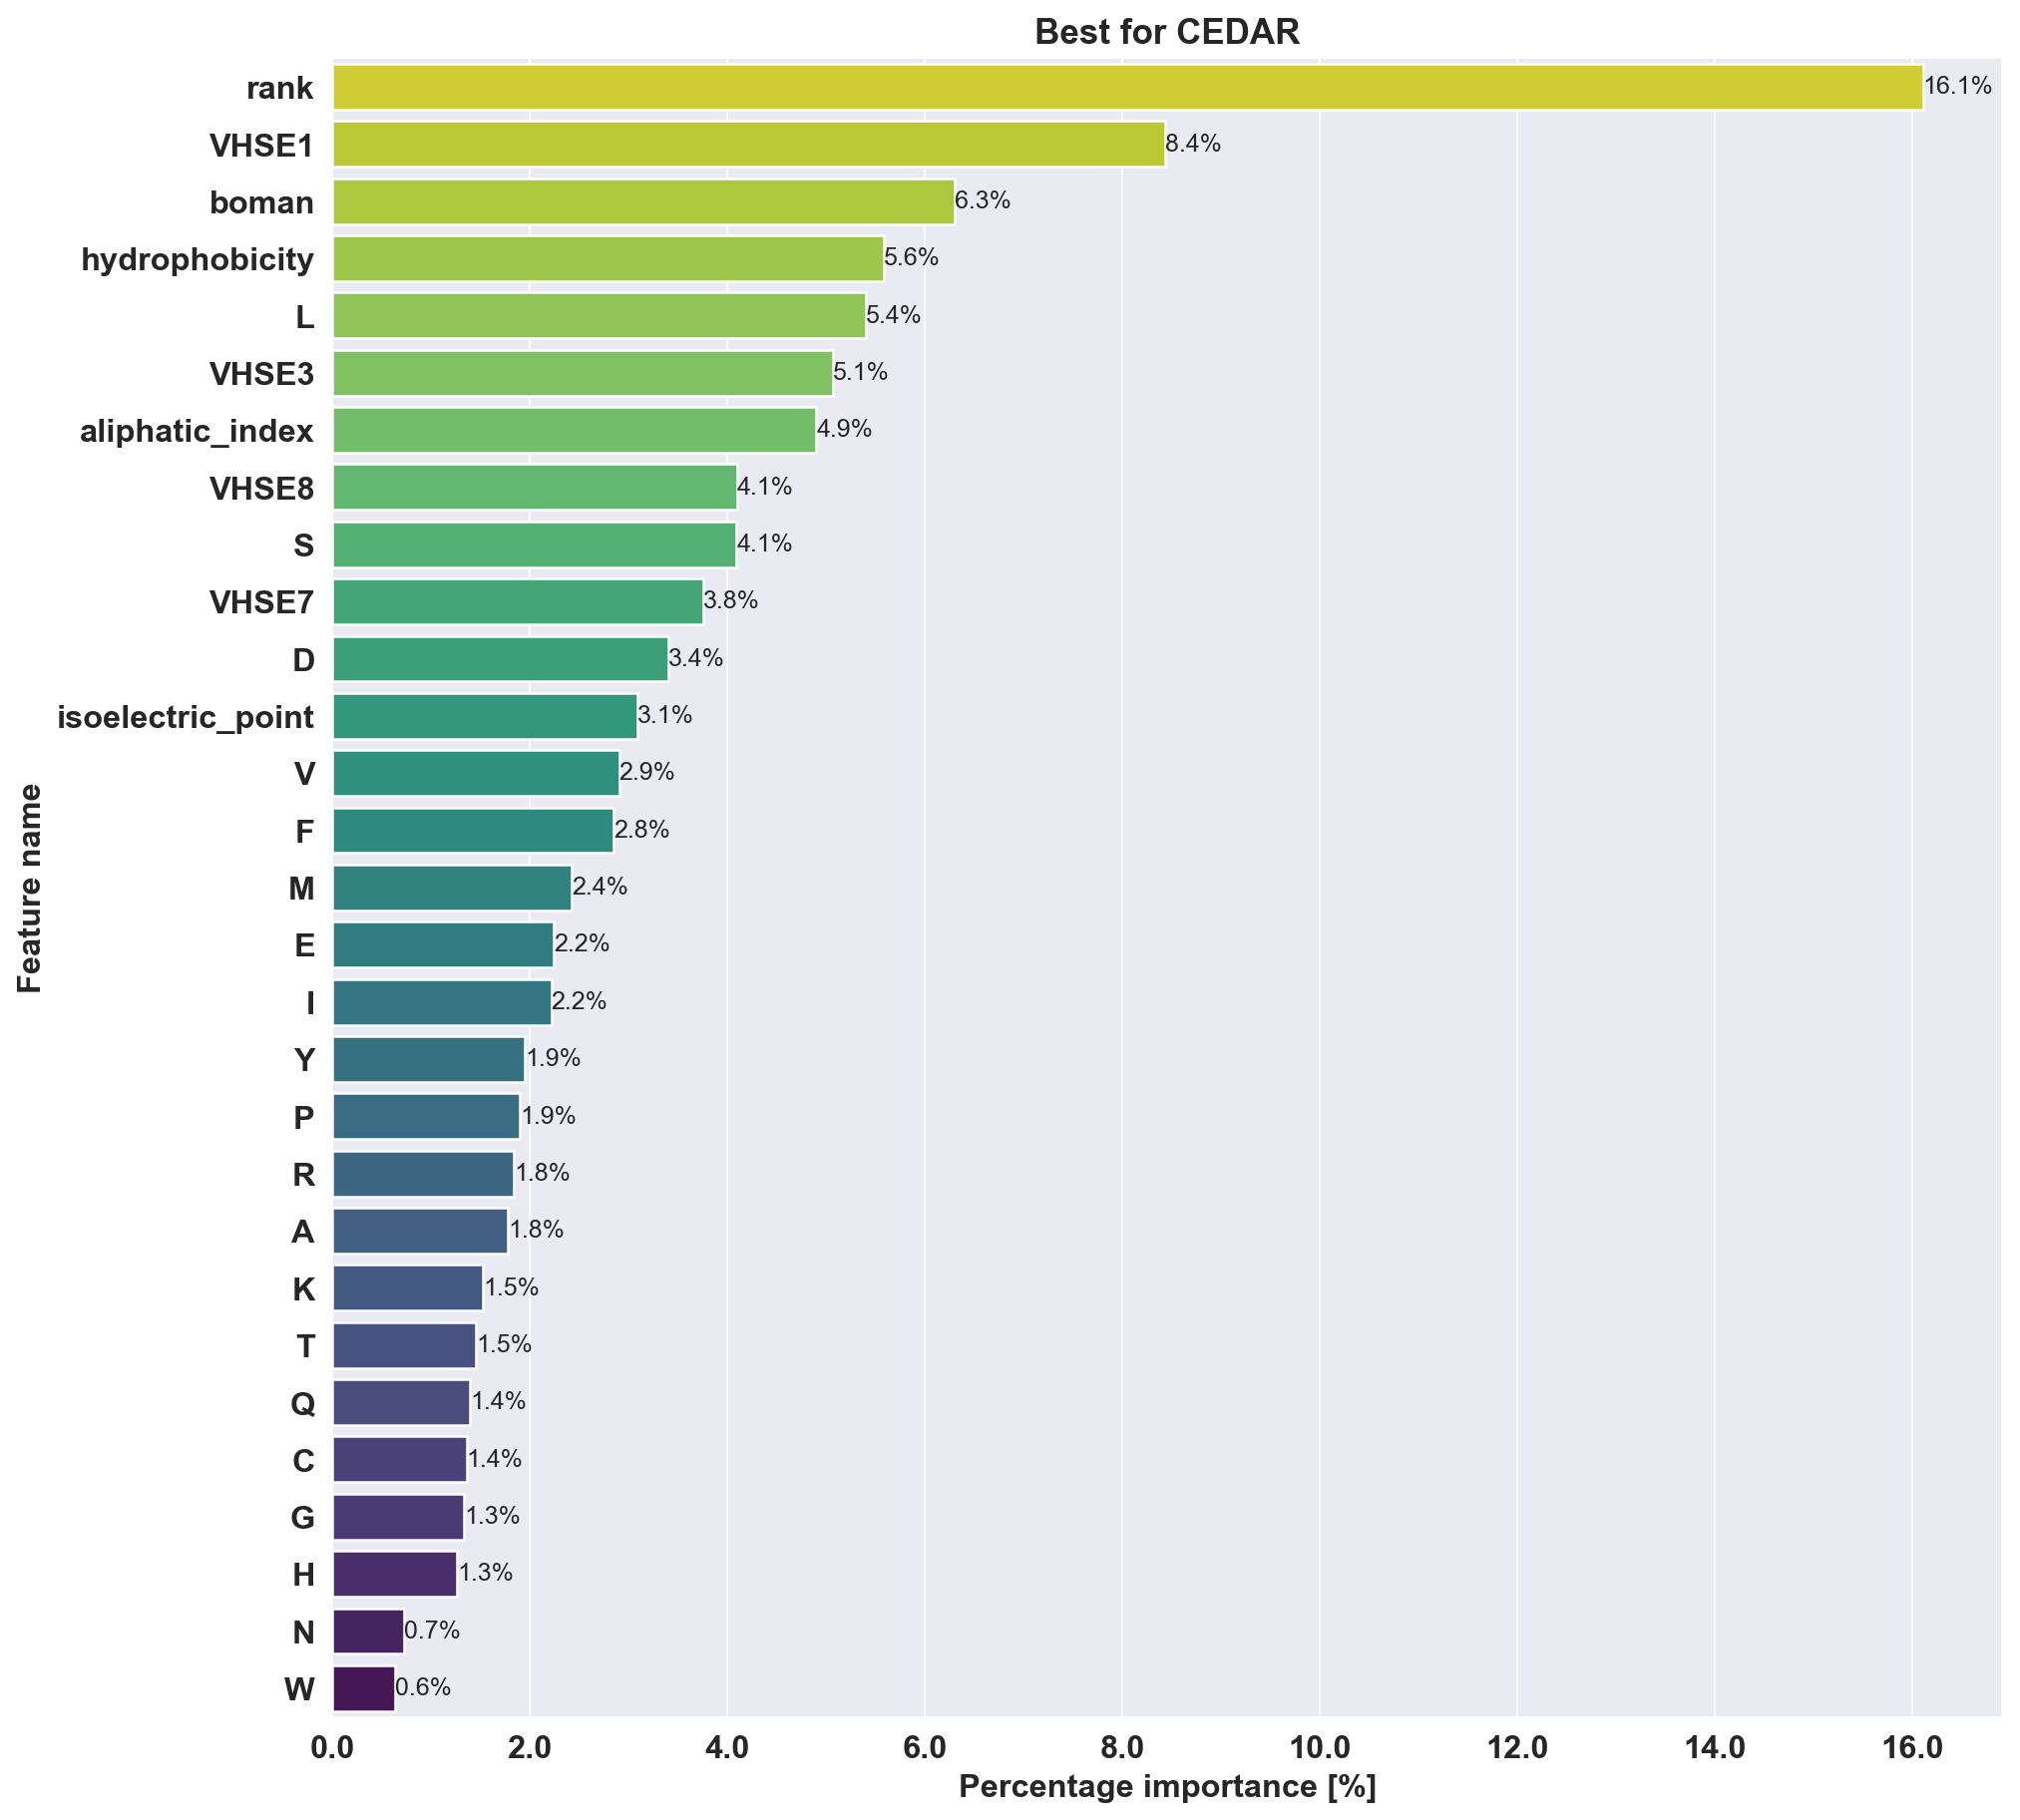

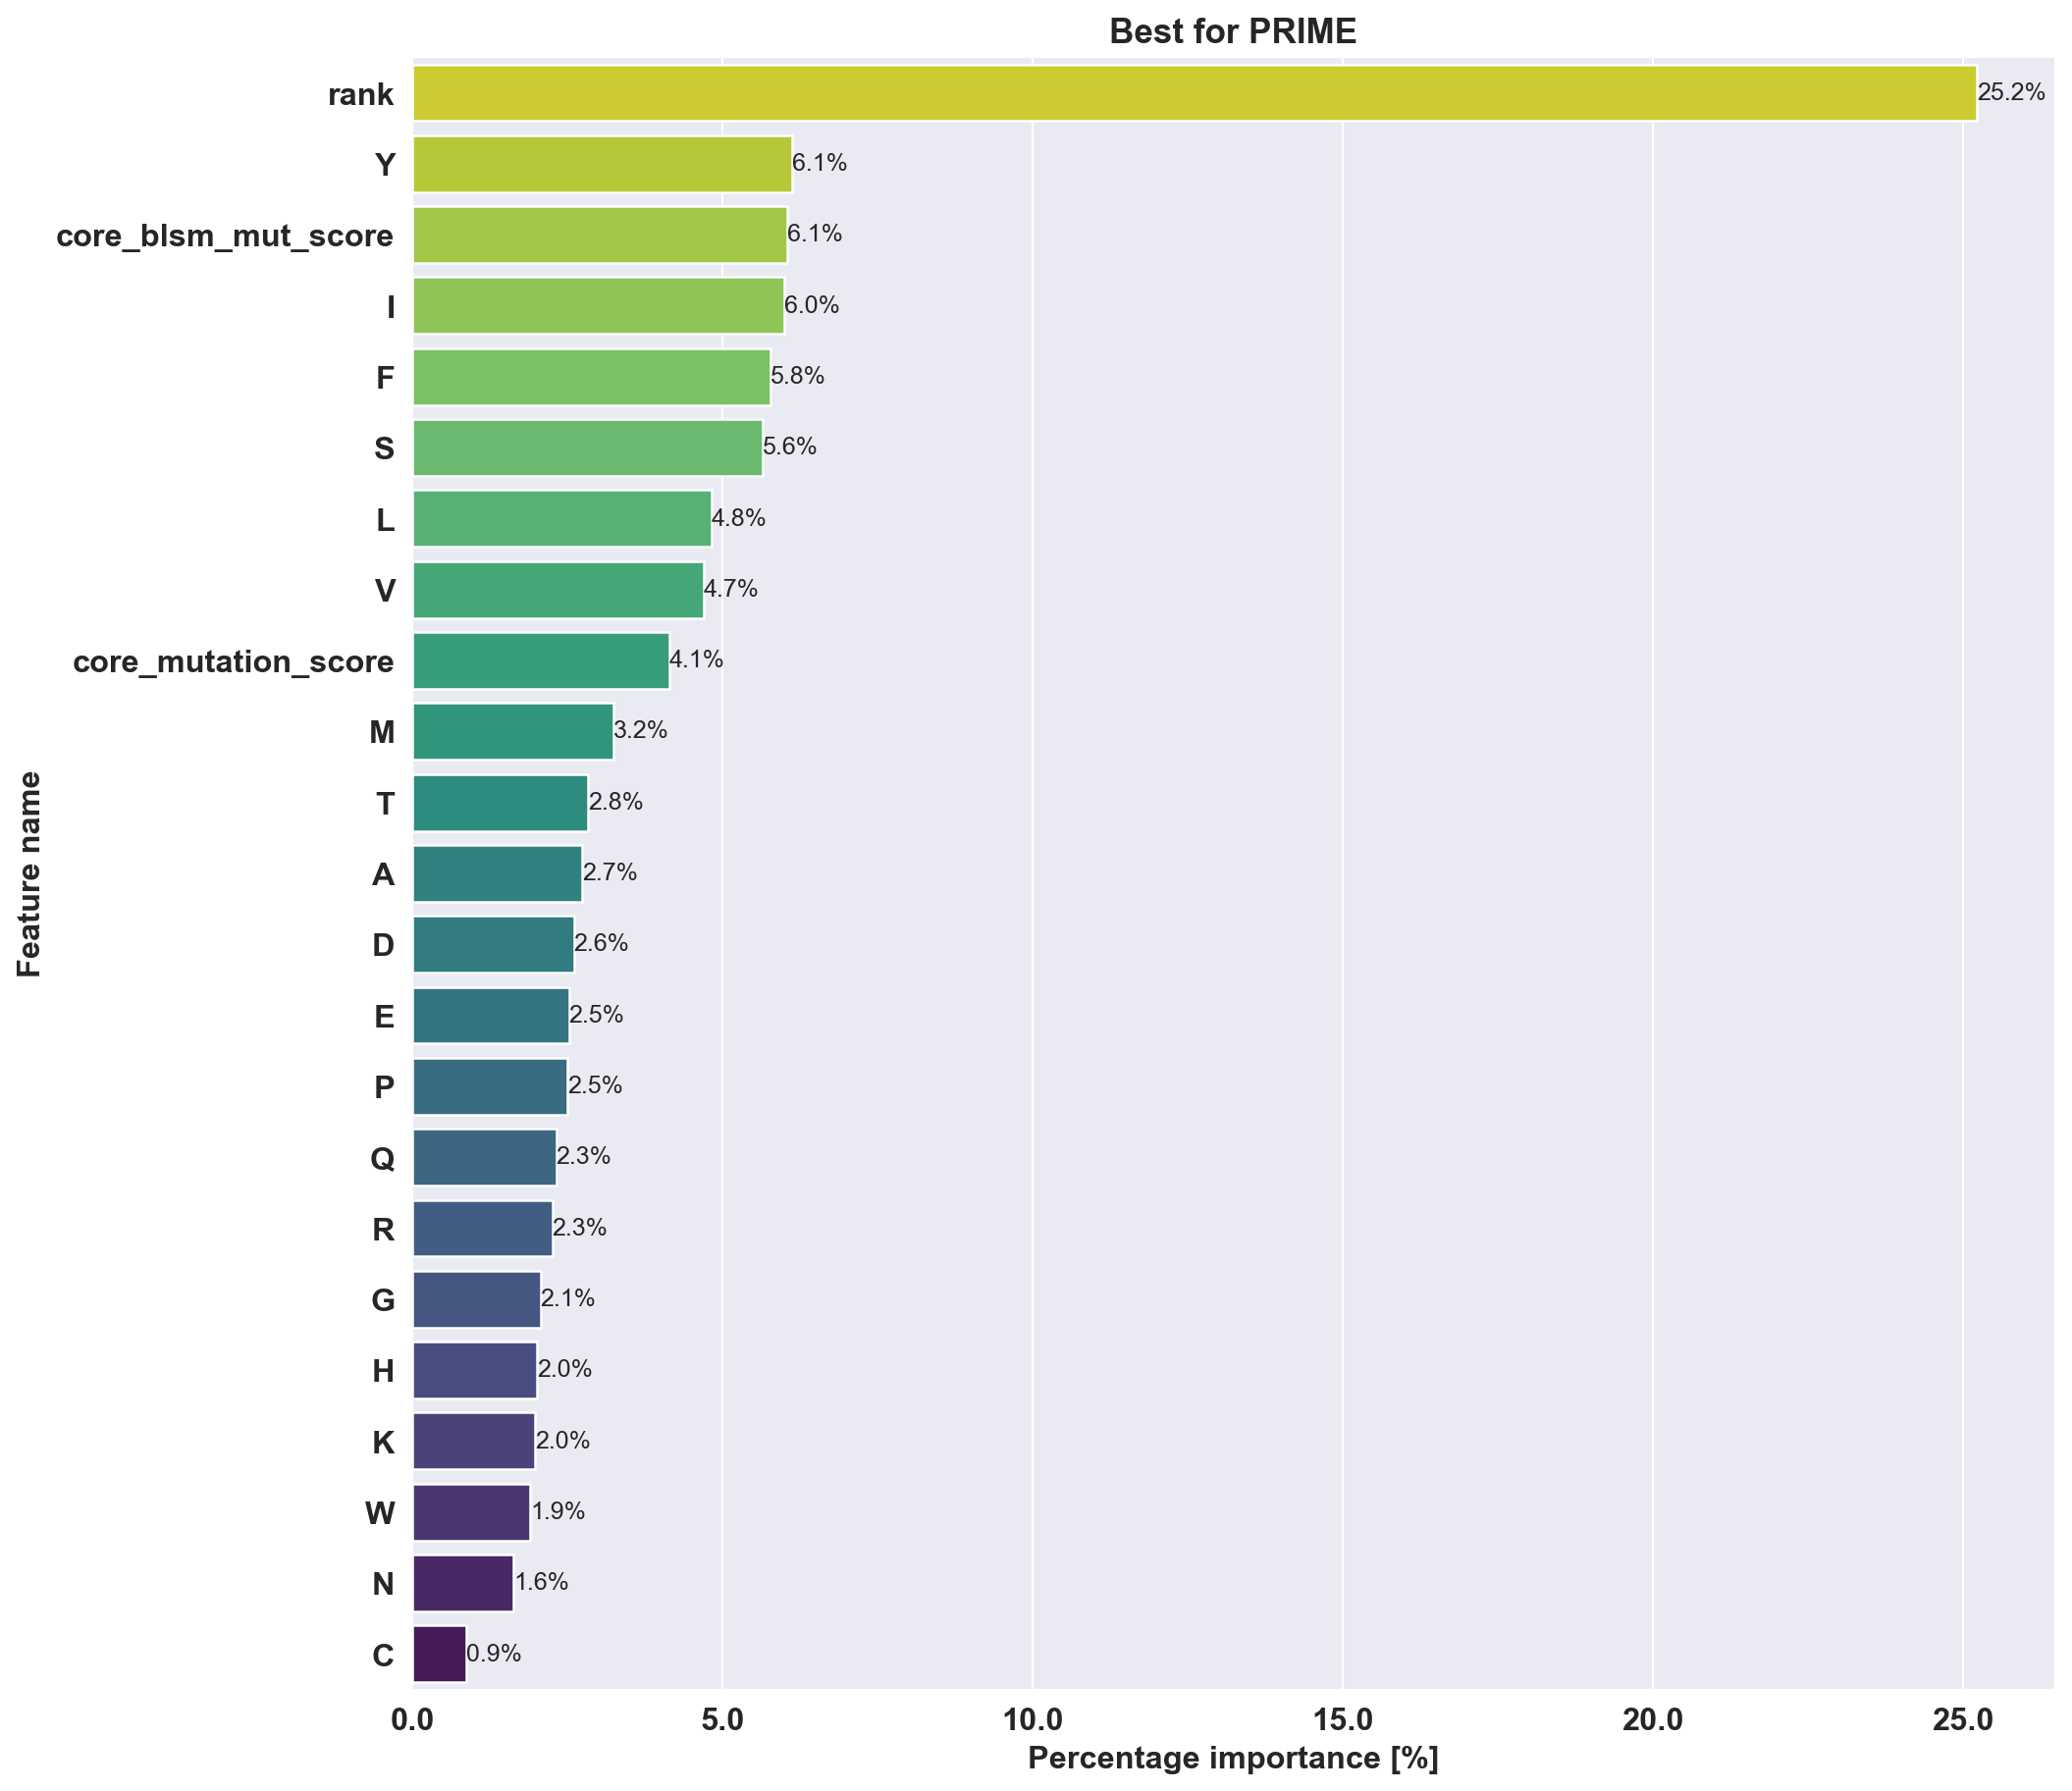

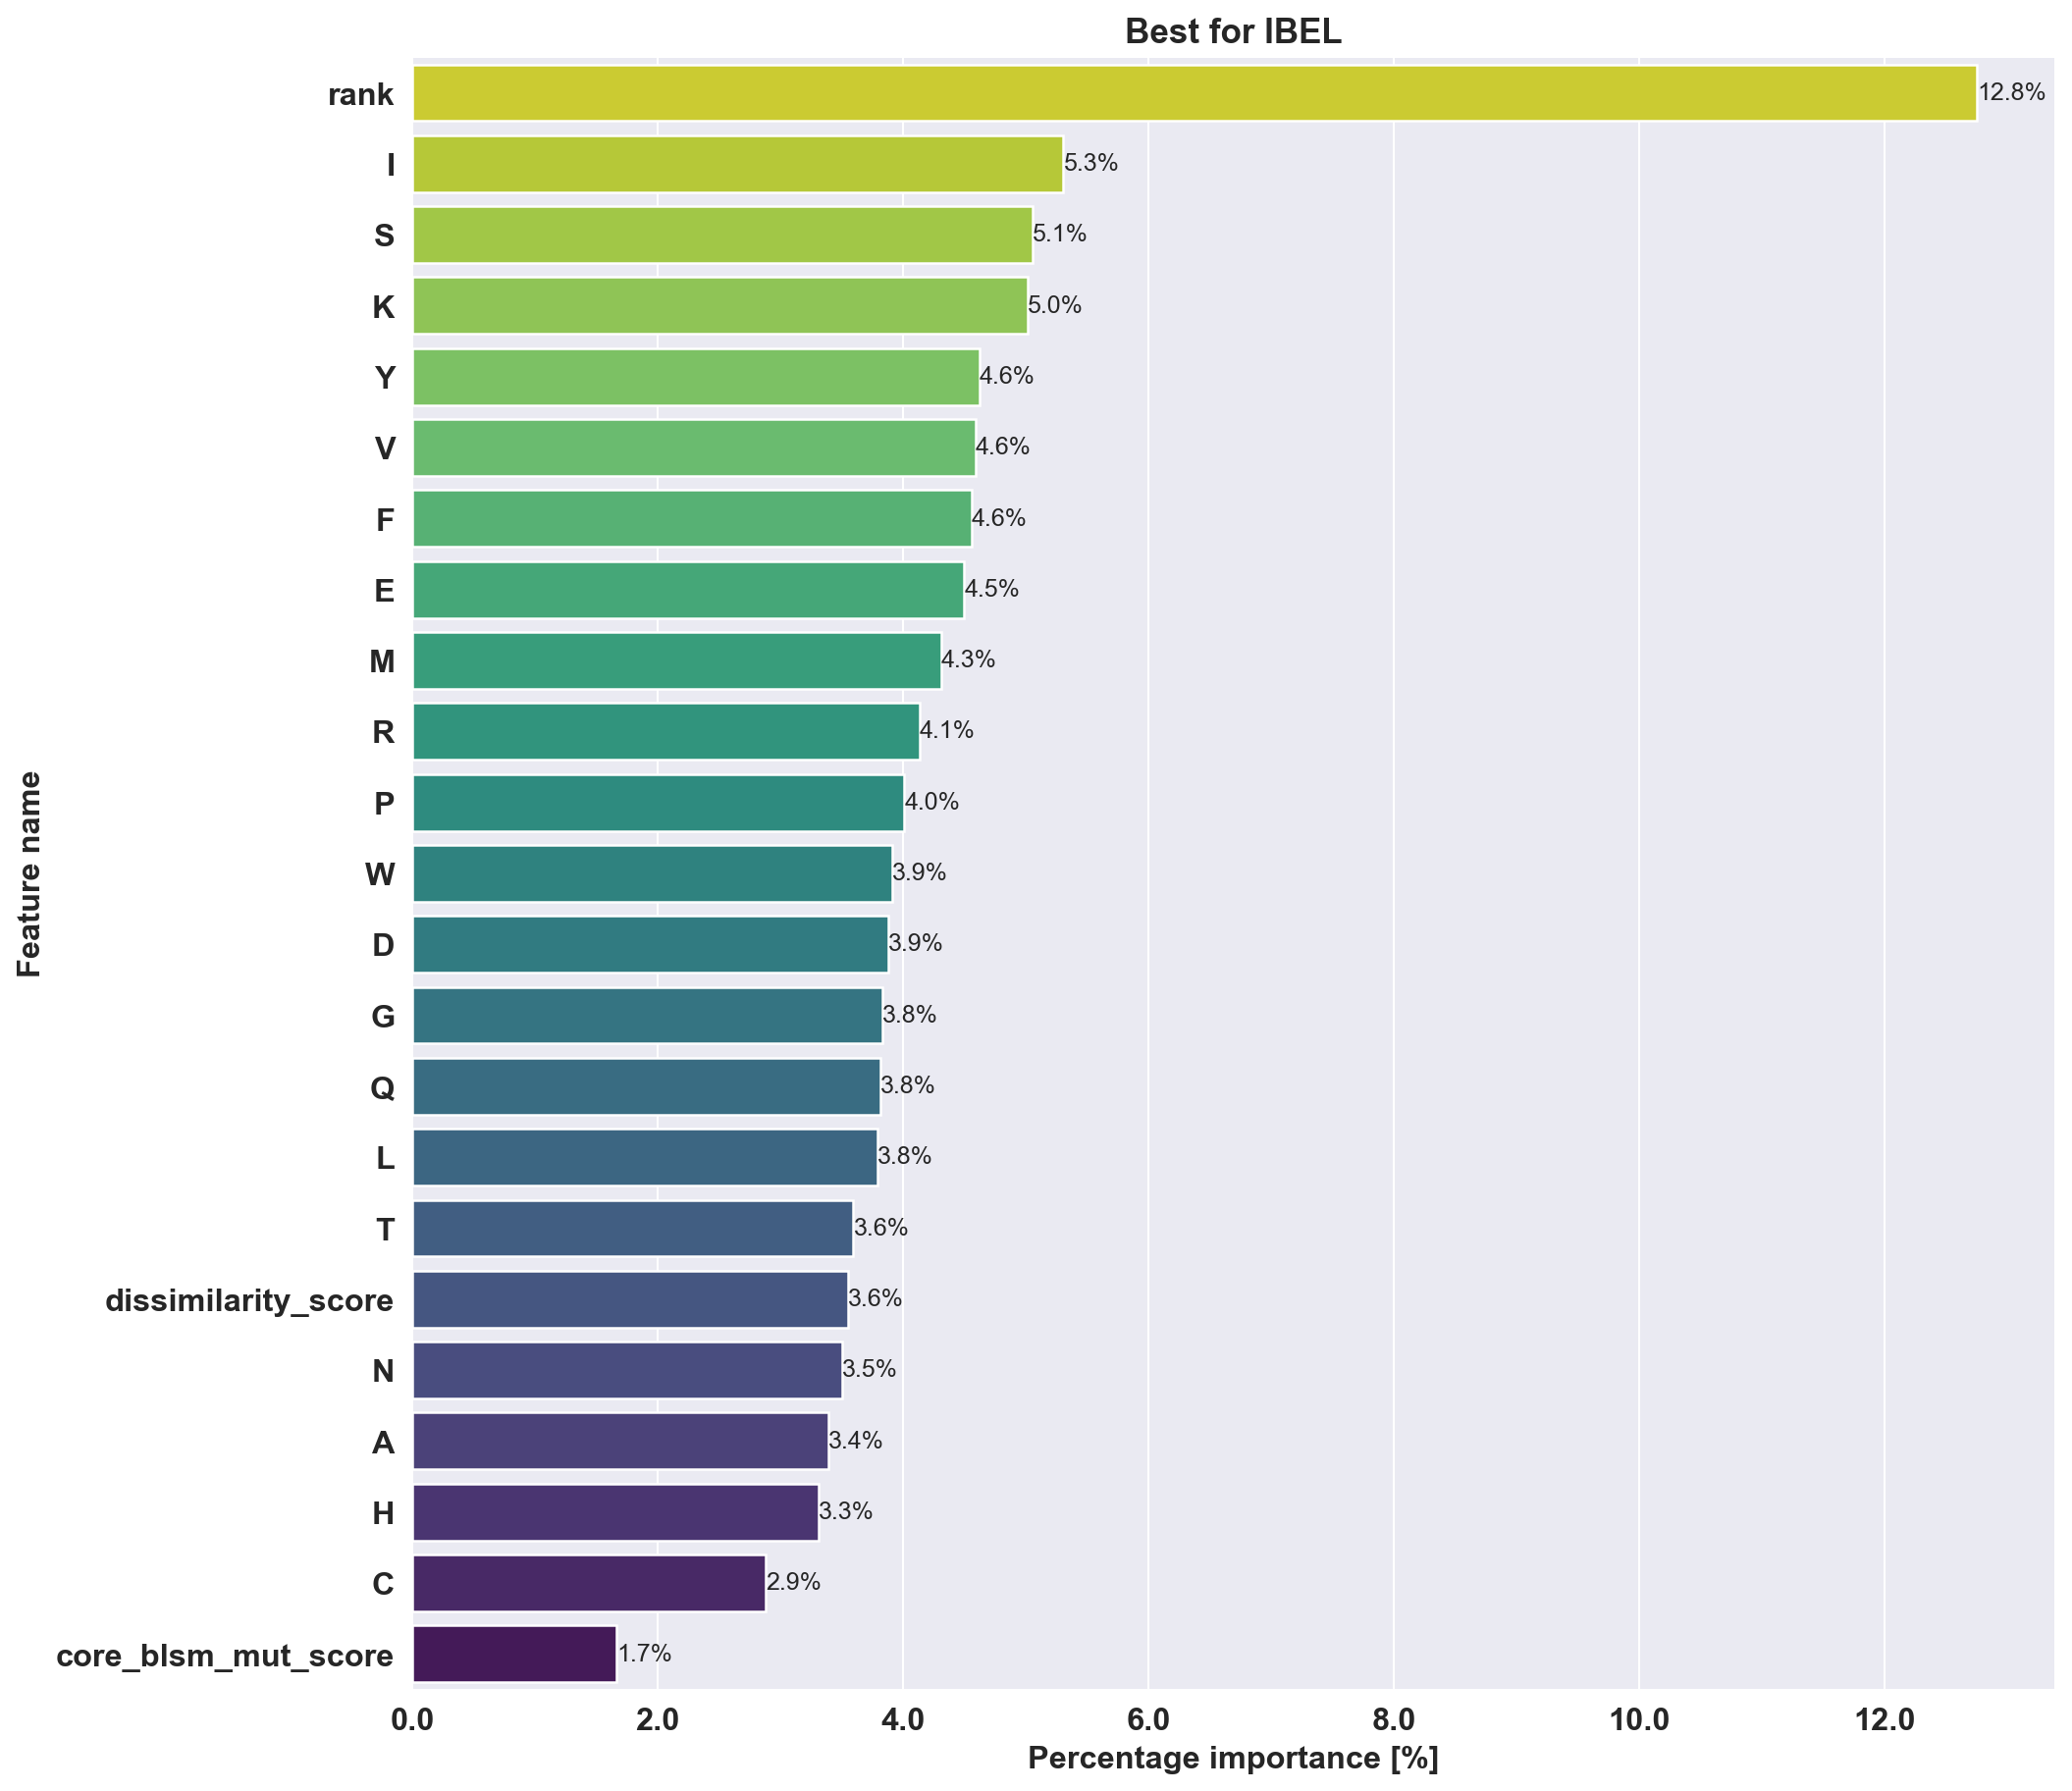

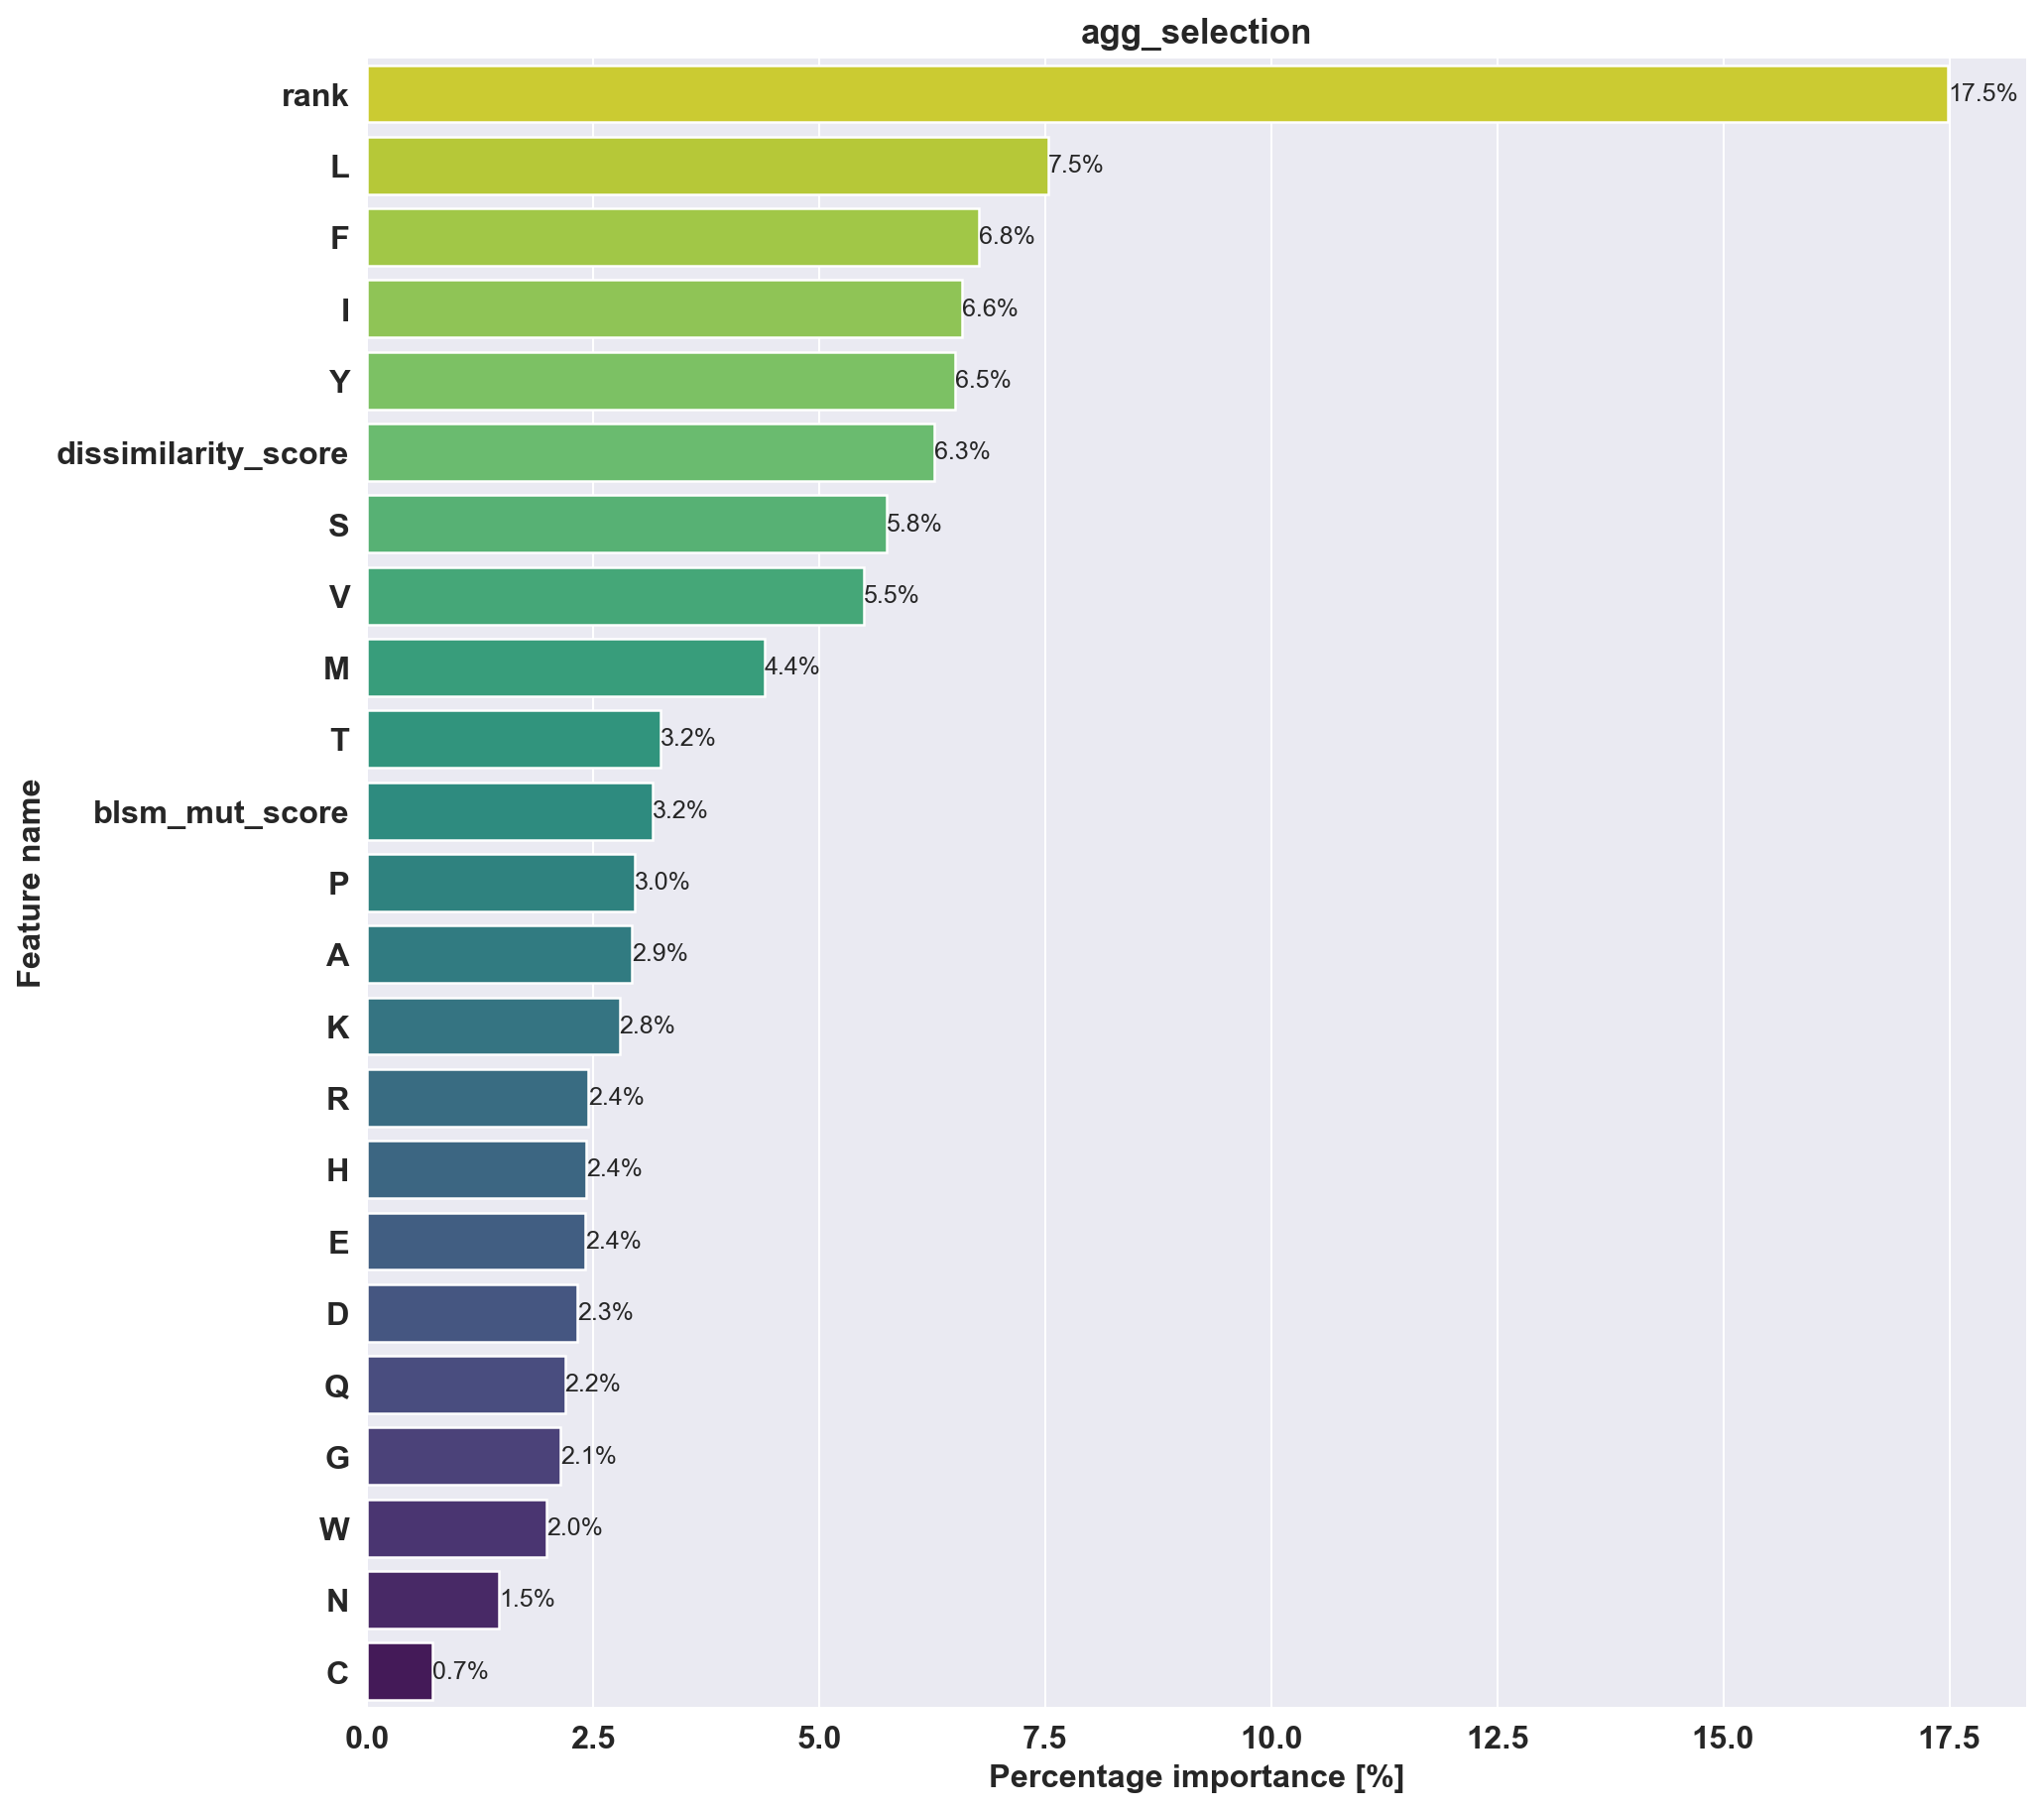

In [319]:
from src.metrics import plot_feature_importance
for k in best_models:
    f,a = plt.subplots(1,1, figsize=(12,12))
    fis = get_fi(**best_models[k]['cdt'])
    plot_feature_importance(fis.squeeze().values, fis.columns, title = k, label_number=True, ax=a)
    a.set_xticklabels(a.get_xticklabels(), fontweight='semibold', fontsize=13)
    a.set_yticklabels(a.get_yticklabels(), fontweight='semibold', fontsize=13)
    a.set_xlabel(a.get_xlabel(), fontweight='semibold', fontsize=13)
    a.set_ylabel(a.get_ylabel(), fontweight='semibold', fontsize=13)
    f.savefig(f"../../../meetings/slides/2301XX_CEDAR_meeting_update/featimps_{'_'.join(k.split(' '))}.png",
              bbox_inches='tight', dpi=200)

# Feature distributions

In [337]:
cedar_related['len_core_mut'] = cedar_related['core_mut'].apply(len)
pd.set_option('display.max_rows',167)
cedar_related.loc[cedar_related.len_icore_mut<cedar_related.len][['Peptide', 'icore_mut', 'core_mut', 'HLA', 'agg_label', 'len', 'len_icore_mut', 'len_core_mut']].query('len>=10 and len_icore_mut>len_core_mut')


,Peptide,icore_mut,core_mut,HLA,agg_label,len,len_icore_mut,len_core_mut
5,AALHTPRPGPL,ALHTPRPGPL,ALHTPRPPL,HLA-B0702,0,11,10,9
22,AEWRNGSTSSL,EWRNGSTSSL,EWNGSTSSL,HLA-A6801,0,11,10,9
23,AFLSTHLKLFL,AFLSTHLKLF,AFLSTHLLF,HLA-A2402,0,11,10,9
45,ALAFTPVEQVV,ALAFTPVEQV,ALFTPVEQV,HLA-A0201,0,11,10,9
62,ALDPHSGHFVA,ALDPHSGHFV,ALDPHSHFV,HLA-A0201,1,11,10,9
135,AMYSNADIYLF,MYSNADIYLF,MYSNAIYLF,HLA-A2402,0,11,10,9
143,APGLMGTEQLF,APGLMGTEQL,APGLMGTQL,HLA-B0702,0,11,10,9
151,APPSAEYESLV,APPSAEYESL,APSAEYESL,HLA-B0702,0,11,10,9
200,ASSVPTGHATF,SSVPTGHATF,SSVPTGHTF,HLA-B1501,0,11,10,9
225,AVFYTILTPVL,AVFYTILTPV,AVFYTILTV,HLA-A0201,0,11,10,9


In [340]:
lmley=1496
cedar_related.loc[[lmley]][['Peptide', 'icore_mut', 'core_mut', 'HLA', 'agg_label', 'trueHLA_EL_rank', 'EL_rank_mut']]

,Peptide,icore_mut,core_mut,HLA,agg_label,trueHLA_EL_rank,EL_rank_mut
1496,LMLEYQKILWK,MLEYQKILWK,MLYQKILWK,HLA-A1101,1,5.1172,2.304


In [322]:
top_hlas = ['HLA-A0201', 'HLA-A1101', 'HLA-A2402', 'HLA-A0301', 'HLA-B0702', 'HLA-B1501', 'HLA-B3501']

# Best IBEL perf